<img src="http://localhost:8888/files/Git_Challenge_Coppel/data/Oferta-de-Trabajo-Coppel.png?_xsrf=2%7Cd8b19ff9%7Ce17b40de014d598595675401dcdeb551%7C1686194522">

# Challenge Analítica Avanzada e Inteligencia Artificial
## Centro de Investigación Coppel

### Elaborado por: Jhonathan Santacana

### Descripción del problema

El objetivo de este problema es desarrollar un modelo de contactabilidad que asocie una probabilidad de contacto a cada cliente en función de ciertos segmentos horarios. Para resolver este problema, se utilizará el archivo 20210513_Challenge_AA.csv, que contiene información sociodemográfica y transaccional de los clientes.

# Análisis preliminar y proceso ETL:
El análisis preliminar y el proceso ETL son pasos importantes en el manejo de datos. El proceso implica cargar los datos del archivo .csv, seleccionar y filtrar el conjunto de datos, y realizar cálculos de estadísticas básicas. También implica la visualización de los datos a través de gráficos y el análisis de las correlaciones entre las variables. Además, se establece un criterio para determinar los factores influyentes en relación con la variable objetivo. Este proceso ayuda a comprender la estructura de los datos, identificar patrones y relaciones, y preparar los datos para su análisis posterior.

Se procede a cargar las librerias a utilizar en la implementacion de la solucion.

In [ ]:
# Librerias a utilizar, por defecto ya vienen instaladas en el entorno "pip install git jupyterlab numpy pandas plotly "
# para mejor visualizacion de los df y manejo de estadisticas:
# ! pip install pandasgui
# ! pip install pandas-profiling
# ! pip install seaborn
# ! pip install scipy
#! pip install optbinning
#! pip install ortools == 9.4.1874
#! pip install -U scikit-learn
import os
import datetime
from IPython.display import clear_output
import pandas as pd
import numpy as np
from pandasgui import show
from ydata_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats import kurtosis
import statsmodels.api as sm
from optbinning import OptimalBinning
from optbinning import BinningProcess
import sklearn
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFE
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, roc_auc_score

print("librerias cargadas correctamente") 

## 0. Revisar Metadata
Se revisan las características del archivo, como el formato, el tipo de datos, los tamaños y las columnas.
En la inspección visual del archivo, se detectaron separadores "|", y debido a su tamaño, se cargarán únicamente 5000 filas para revisar una parte del mismo. Esto nos permitirá visualizar rápidamente el número de columnas y los tipos de datos

In [6]:
df = pd.read_csv("..\\datos_internos\\20210513_Challenge_AA.csv", sep="|", nrows=5000)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ANIO             5000 non-null   int64  
 1   MES              5000 non-null   int64  
 2   CLIENTE          5000 non-null   int64  
 3   ESTADO           5000 non-null   object 
 4   INGRESO          4918 non-null   float64
 5   MORAS            5000 non-null   int64  
 6   SEXO             5000 non-null   object 
 7   ESTADOCIVIL      5000 non-null   object 
 8   FECHANACIMIENTO  5000 non-null   object 
 9   MARCACIONES      5000 non-null   int64  
 10  CONTACTOS        5000 non-null   int64  
 11  M1               5000 non-null   int64  
 12  C1               5000 non-null   int64  
 13  M2               5000 non-null   int64  
 14  C2               5000 non-null   int64  
 15  M3               5000 non-null   int64  
 16  C3               5000 non-null   int64  
 17  ANTIGUEDAD    

In [3]:
df.head()

,ANIO,MES,CLIENTE,ESTADO,INGRESO,MORAS,SEXO,ESTADOCIVIL,FECHANACIMIENTO,MARCACIONES,...,M1,C1,M2,C2,M3,C3,ANTIGUEDAD,EDAD,HORARIO,TARGET
0,2019,5,2019539059618,JALISCO,15000.0,3,M,S,1966-02-01 00:00:00.000000,347,...,19,0,0,0,130,0,1,53,MEDIODIA,1
1,2019,5,2019539059618,JALISCO,15000.0,3,M,S,1966-02-01 00:00:00.000000,347,...,19,0,0,0,130,0,1,53,TARDE,1
2,2019,5,2019539059618,JALISCO,15000.0,3,M,S,1966-02-01 00:00:00.000000,347,...,19,0,0,0,130,0,1,53,NOCHE,1
3,2019,5,2019539059618,JALISCO,15000.0,3,M,S,1966-02-01 00:00:00.000000,347,...,19,0,0,0,130,0,1,53,MANANA,1
4,2019,5,2019527392560,VERACRUZ,6000.0,6,M,C,1987-07-04 00:00:00.000000,113,...,71,3,42,0,30,0,5,31,NOCHE,0


La visualizacion de los datos permite hacer varios tipos de clasificacion preliminar:

categoricas = {'nominales': ['ANIO', 'MES', 'CLIENTE', 'ESTADO', 'INGRESO', 'MORAS', 'SEXO',  'ESTADOCIVIL', 'FECHANACIMIENTO', 'MARCACIONES', 'CONTACTOS3', 'ANTIGUEDAD', 'EDAD', 'TARGET'], 
            'ordinales': [], 
             'Desconocido'['M1', 'C1', 'M2', 'C2', 'M3', 'C3']}
                
numerica = {'continuas': ['INGRESO'],
            'discretas': ['ANIO', 'MES', 'MORAS', 'MARCACIONES', 'CONTACTOS', 'EDAD','ANTIGUEDAD'], 
            }

cualidad = {'Cuantitativa Intervalo': ['ANIO', 'MES', 'INGRESO', 'MORAS', 'MARCACIONES', 'CONTACTOS','EDAD'], 
            'Cuantitativa Razon': ['ANTIGUEDAD'], 
            'Cualitativa Nominal': ['CLIENTE', 'ESTADO', 'SEXO', 'ESTADOCIVIL', 'FECHANACIMIENTO', 'HORARIO', 'TARGET'], 
            'Desconocido': ['M1', 'C1', 'M2', 'C2', 'M3', 'C3']}

La clasificación de las variables en categóricas y numéricas es importante en el modelado de machine learning porque los algoritmos y técnicas utilizados pueden variar según el tipo de variable. Por ejemplo, para las variables categóricas, se pueden aplicar técnicas como la codificación one-hot o la codificación ordinal para convertirlas en variables numéricas antes de utilizar ciertos algoritmos de machine learning. Por otro lado, las variables numéricas pueden requerir normalización o escalado antes de aplicar ciertos algoritmos para asegurar que todas las variables tengan el mismo rango o importancia relativa en el modelo.

Se asumira que las variables desconocidas se comportan como categóricas ordinales, Cuantitativas de Intervalo.

In [9]:
print(f"Los horarios para clasificacion son {list(df['HORARIO'].unique())}")

Los horarios para clasificacion son ['MEDIODIA', 'TARDE', 'NOCHE', 'MANANA']


## 1. Cargar los datos del archivo .csv
Se realizara la carga de los datos del archivo .csv en el entorno de trabajo.
 Para manejar eficientemente grandes volúmenes de datos, los datos del archivo .csv se cargan por partes utilizando el iterador chunksize, lo que permite procesarlos de manera incremental.

## 2. Seleccionar horario, aplicar filtro y trabajar con un dataframe más pequeño

Se construye la clase CargadorCSV que se utiliza para cargar archivos con formato .csv y realizar ciertas operaciones sobre ellos.

El constructor de la clase recibe la ruta del archivo a cargar.

La función "visualizar_avance" muestra el progreso de la carga del archivo en porcentaje.

La función "crear_csv_por_horarios" divide el archivo original en varios archivos CSV separados según ciertos horarios. Para cada chunk del archivo original, se filtran los datos por horario y se guardan en archivos CSV individuales. También se guarda un archivo adicional para los valores perdidos.

Este enfoque facilita el análisis específico para cada horario en particular y permite trabajar con los datos de manera más eficiente.

In [ ]:
class CargadorCSV:
    """Clase para carga de archivos con formato .csv"""
    def __init__(self, file_path):
        """
        Constructor de la clase. Recibe la ruta del archivo.
        """
        self.file_path = file_path
    
    def visualizar_avance(self, bytes_avance, bytes_completo):
        """Visualiza el avance de la carga del archivo en porcentaje."""
        avance = min(round(bytes_avance / bytes_completo, 2) * 100, 100)
        clear_output(wait=True)
        print(f"Avance estimado: {avance}%")
    
    def crear_csv_por_horarios(self, chunk_size=100000, sep="|"):
        """Crea archivos CSV separados por horarios a partir del archivo original."""
        try:
            bytes_completo = os.path.getsize(self.file_path)
            encabezado = True
            horarios = ['MEDIODIA', 'TARDE', 'NOCHE', 'MANANA']
            
            for chunk in pd.read_csv(self.file_path, sep=sep, chunksize=chunk_size):
                bytes_avance = 0
                
                if encabezado:
                    for clasificador_horario in horarios:
                        df_filtered = chunk.loc[chunk["HORARIO"] == clasificador_horario].drop("HORARIO", axis=1)
                        file_name = f"{self.file_path[:-4]}_{clasificador_horario}.csv"
                        df_filtered.to_csv(file_name, index=False)
                        bytes_avance += os.path.getsize(file_name)
                    df_Nofiltered = chunk.loc[~chunk["HORARIO"].isin(horarios)]
                    df_Nofiltered.to_csv(f"{self.file_path[:-4]}_ValoresPerdidos.csv ", index=False)
                    
            #df_MANANA_filtered = df_MANANA.loc[~df_MANANA["MES"].isin(months_to_exclude)]
                    encabezado = False
                else:
                    for clasificador_horario in horarios:
                        df_filtered = chunk.loc[chunk["HORARIO"] == clasificador_horario].drop("HORARIO", axis=1)
                        file_name = f"{self.file_path[:-4]}_{clasificador_horario}.csv"
                        df_filtered.to_csv(file_name, mode='a', index=False, header=False)
                        bytes_avance += os.path.getsize(file_name)
                    df_Nofiltered = chunk.loc[~chunk["HORARIO"].isin(horarios)]
                    df_Nofiltered.to_csv(f"{self.file_path[:-4]}_ValoresPerdidos.csv ",mode = 'a', index=False, header=False)                   
                
                self.visualizar_avance(bytes_avance, bytes_completo)
            #clear_output(wait=True)
            print(f"Proceso terminado")
        except Exception as error:
            print("Ocurrió un error:", error)

In [ ]:
# Leer el archivo .csv original y guardar el archivo por partes según los horarios
cargador = CargadorCSV("..\\datos_internos\\20210513_Challenge_AA.csv") 
cargador.crear_csv_por_horarios()

De existir valores que no entren en la clasificacion de horarios se almacenan en el archivo 20210513_Challenge_AA_ValoresPerdidos.csv, al revisarlo se puede confirmar que no exiten valores perdidos.

In [11]:
df_perdidos = pd.read_csv("..\\datos_internos\\20210513_Challenge_AA_ValoresPerdidos.csv")
df_perdidos.shape

(0, 21)

## 3. Indicar las dimensiones del nuevo archivo

Cargamos la data filtrada para analizar el número de observaciones, valores nulos, inconcistencias en tipo de dato y outliers, Indicando el número de filas y columnas en el nuevo archivo, así como los nombres de las variables y una descripción general de los datos.

La clase revisor_data_csv se utiliza para cargar y revisar archivos con formato .csv. Permite realizar diferentes operaciones y análisis en función de los datos cargados.

El constructor de la clase recibe la ruta del archivo y carga el archivo en un DataFrame utilizando la biblioteca pandas. También crea otro DataFrame para registrar los cambios realizados en los datos.

La función "mensaje" se utiliza para mostrar mensajes durante la carga del archivo, como "Cargando archivo..." y "Carga completa".

La función "analisis_nulos" realiza un análisis de los valores nulos en el DataFrame cargado y devuelve un nuevo DataFrame con la cantidad y el porcentaje de valores nulos para cada columna.

Las funciones "nulos_EliminacionSimple" y "nulos_MediaCondicional" se utilizan para manejar los valores nulos en el DataFrame. La primera elimina las filas que contienen valores nulos en las columnas indicadas por una lista. La segunda asigna el valor promedio de la columna variable a los valores nulos, agrupando por las columnas indicadas en otra lista.

La función "eliminar_por_condicion" elimina las filas que contienen un valor específico en una columna determinada.

In [5]:
class revisor_data_csv:
    """Clase para carga y revisión de archivos con formato .csv
    Con esto podemos visualizar y manipular la data de forma controlada minimizando errores y
    pudiendo posteriormente crar un pipeline del proceso ETL"""
    def __init__(self, file_path):
        """
        Constructor de la clase que recibe la ruta del archivo y carga el archivo
        Se asume archivos .csv estándar, sep = ","
        """
        self.file_path = file_path
        try:
            # Se carga el df 
            self.mensaje("cargando", self.file_path)
            self.df = pd.read_csv(self.file_path)
            self.mensaje("cargado")
        except Exception as error:
            print("Ocurrió un error:", error)
            
    def mensaje(self, tipo, arg=None):
        tipos_mensajes = {"cargando": f"Cargando archivo {arg}",
                          "cargado": "Carga completa"}
        if tipo in tipos_mensajes:
            clear_output(wait=True)
            print(tipos_mensajes[tipo])
        else:
            clear_output(wait=True)
            print("Tipo de mensaje no válido")
            print(f"{list(tipos_mensajes.keys())}")
    
    def analisis_nulos(self):
        cuenta_nulos = self.df.isnull().sum()
        cuenta_nulos = cuenta_nulos[cuenta_nulos != 0]
        porcentaje_nulos = round((cuenta_nulos / self.df.shape[0]) * 100, 2)
        return pd.DataFrame({"cant_nulos": cuenta_nulos, "porcentaje_nulos": porcentaje_nulos})

    def nulos_EliminacionSimple(self, lista):
        """Se eliminarán las filas que contengan valores nulos en las columnas indicadas por la lista"""
        try:
            self.df = self.df.dropna(subset=lista)
        except Exception as error:
            print("Ocurrió un error:", error)

    def nulos_MediaCondicional(self, variable, lista):
        """Se asignará a los valores nulos de la columna variable,
        el valor promedio agrupando con las columnas indicadas por la lista"""
        try:
            self.df.loc[self.df[variable].isnull(), variable] = self.df.groupby(lista, as_index=False)[[variable]].transform('mean')
        except Exception as error:
            print("Ocurrió un error:", error)

    def eliminar_por_condicion(self,columna,condicion):
        """Se eliminarán las filas que contengan valores 'condicion' en la columna indicadas por la lista"""
        try:
            self.df = self.df.drop(self.df[self.df[columna] == condicion].index)
        except Exception as error:
            print("Ocurrió un error:", error)

Seleccionamos un clasificacion temporal para trabajar...

In [9]:
revision = revisor_data_csv("..\\datos_internos/20210513_Challenge_AA_MANANA.csv")

### 3.1. Visualizacion dimensión del nuevo fichero y estructura de los datos.

In [10]:
revision.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9270223 entries, 0 to 9270222
Data columns (total 20 columns):
 #   Column           Dtype  
---  ------           -----  
 0   ANIO             int64  
 1   MES              int64  
 2   CLIENTE          int64  
 3   ESTADO           object 
 4   INGRESO          float64
 5   MORAS            float64
 6   SEXO             object 
 7   ESTADOCIVIL      object 
 8   FECHANACIMIENTO  object 
 9   MARCACIONES      int64  
 10  CONTACTOS        int64  
 11  M1               int64  
 12  C1               int64  
 13  M2               int64  
 14  C2               int64  
 15  M3               int64  
 16  C3               int64  
 17  ANTIGUEDAD       float64
 18  EDAD             float64
 19  TARGET           int64  
dtypes: float64(4), int64(12), object(4)
memory usage: 1.4+ GB


In [11]:
revision.df.head()

,ANIO,MES,CLIENTE,ESTADO,INGRESO,MORAS,SEXO,ESTADOCIVIL,FECHANACIMIENTO,MARCACIONES,CONTACTOS,M1,C1,M2,C2,M3,C3,ANTIGUEDAD,EDAD,TARGET
0,2019,5,2019539059618,JALISCO,15000.0,3.0,M,S,1966-02-01 00:00:00.000000,347,8,19,0,0,0,130,0,1.0,53.0,1
1,2019,5,2019527392560,VERACRUZ,6000.0,6.0,M,C,1987-07-04 00:00:00.000000,113,0,71,3,42,0,30,0,5.0,31.0,0
2,2019,5,201958823716,CHIAPAS,4000.0,1.0,F,S,1980-05-07 00:00:00.000000,177,4,100,11,13,1,14,4,0.0,39.0,0
3,2019,5,201953294752,TAMAULIPAS,4000.0,5.0,M,U,1989-08-30 00:00:00.000000,139,0,176,1,159,11,73,11,1.0,29.0,0
4,2019,5,2019568646789,ESTADO DE MEXICO,5000.0,3.0,F,U,1968-05-16 00:00:00.000000,89,5,28,8,11,3,0,0,0.0,51.0,0


In [12]:
# Para revision posterior de total de resgistros perdidos en proceso ETL
registros_inicial = revision.df.shape[0]
print(f"Inicialmente el data set consta de {registros_inicial} registros")

Inicialmente el data set consta de 9270223 registros


### 3.2. Manejo valores nulos 

Se procede a evaluar los valores nulos, porque estos pueden afectar al momento de querere modificar los tipos de dato, la mejor forma de Visualizar la cantidad de valores nulos es porcentual con respecto al tamaño de la base de datos.

In [13]:
revision.analisis_nulos()

,cant_nulos,porcentaje_nulos
INGRESO,179892,1.94
MORAS,2815,0.03
SEXO,2815,0.03
ESTADOCIVIL,2815,0.03
FECHANACIMIENTO,2815,0.03
ANTIGUEDAD,2815,0.03
EDAD,2815,0.03


Existen diversas formas de abordar los valores nulos en los datos: Eliminacion simple, imputación por valor constante, por valor medio/mediana, regresión,media condicional o vecinos más cercanos. En este caso, se utilizarán dos métodos:

Para aquellas variables (MORAS, SEXO, ESTADOCIVIL, FECHANACIMIENTO, ANTIGUEDAD, EDAD) que representan el 0.03% de los datos, se procederá a aplicar eliminacion simple. Dado que este porcentaje es muy pequeño en relación al análisis general, su exclusión no debería tener un impacto significativo en los resultados.

En el caso de la variable 'INGRESO', se realizará imputación por media condicional, reemplazar los valores nulos con la media de la columna condicionada a otras características del conjunto de datos. Es importante destacar que esta aproximación asume que el comportamiento de la variable 'INGRESO' sigue una distribución relativamente normal. 

In [14]:
# Eliminacion de valores nulos
revision.nulos_EliminacionSimple(['MORAS', 'SEXO', 'ESTADOCIVIL', 'FECHANACIMIENTO', 'ANTIGUEDAD', 'EDAD'])
revision.analisis_nulos()

,cant_nulos,porcentaje_nulos
INGRESO,177077,1.91


In [15]:
# Promedio de ajustado para valores nulos
revision.nulos_MediaCondicional('INGRESO',['ESTADO','EDAD','ESTADOCIVIL','SEXO'])
revision.analisis_nulos()

,cant_nulos,porcentaje_nulos
INGRESO,606,0.01


Sin embargo, pueden quedar unos valores nulos que no tengan promedio, pero nuevamente al ser una cantidad muy pequeña, se puede eliminar esos registros.

In [16]:
revision.nulos_EliminacionSimple(['INGRESO'])
revision.analisis_nulos()

,cant_nulos,porcentaje_nulos


### 3.3. Incosistencias de Tipo de dato

Una vez resuelto el problema de valores nulos se pueden identificar las siguientes inconsistencias de tipo:

| Índice | Variable         | Inconsistencia                                      |
|-------:|------------------|----------------------------------------------------|
|      0 | ANIO             | No hay inconsistencias. Valores válidos: [2019,2020]        |
|      1 | MES              | No hay inconsistencias. Valores válidos: enteros del 1 al 12    |
|      2 | CLIENTE          | No hay inconsistencias.                                      |
|      3 | ESTADO           | No hay inconsistencias. 32 estados coinciden con estados mexicanos. |
|      4 | INGRESO          | No hay inconsistencias.                                     |
|      5 | MORAS            | Se entiende que está en unidades enteras, no puede haber moras fraccionarias. Debe ser de tipo entero (int).  |
|      6 | SEXO             | No hay inconsistencias.                                      |
|      7 | ESTADOCIVIL      | No hay inconsistencias.                                      |
|      8 | FECHANACIMIENTO  | No está reconocida como un datetime.                             |
|      9 | MARCACIONES      | No hay inconsistencias.                                      |
|     10 | CONTACTOS        | No hay inconsistencias.                                      |
|     11 | M1               | No hay inconsistencias.                                      |
|     12 | C1               | No hay inconsistencias.                                      |
|     13 | M2               | No hay inconsistencias.                                      |
|     14 | C2               | No hay inconsistencias.                                      |
|     15 | M3               | No hay inconsistencias.                                      |
|     16 | C3               | No hay inconsistencias.                                      |
|     17 | ANTIGUEDAD       | Se asumirá que debe ser de tipo entero (int).                   |
|     18 | EDAD             | Debe ser de tipo entero (int).                               |
|     19 | TARGET           | No hay inconsistencias.                                      |

En resumen, se identificaron las inconsistencias de tipo en las variables y se propusieron las correcciones correspondientes en cuanto al tipo de dato esperado.

In [17]:
# correciones de tipo en datos:
revision.df['MORAS'] = revision.df['MORAS'].astype(int)
revision.df['ANTIGUEDAD'] = revision.df['ANTIGUEDAD'].astype(int)
revision.df['EDAD'] = revision.df['EDAD'].astype(int)
revision.df['FECHANACIMIENTO'] = pd.to_datetime(revision.df['FECHANACIMIENTO']).dt.date
revision.df['FECHANACIMIENTO'] = pd.to_datetime(revision.df['FECHANACIMIENTO'])

In [18]:
revision.df.dtypes

ANIO                        int64
MES                         int64
CLIENTE                     int64
ESTADO                     object
INGRESO                   float64
MORAS                       int32
SEXO                       object
ESTADOCIVIL                object
FECHANACIMIENTO    datetime64[ns]
MARCACIONES                 int64
CONTACTOS                   int64
M1                          int64
C1                          int64
M2                          int64
C2                          int64
M3                          int64
C3                          int64
ANTIGUEDAD                  int32
EDAD                        int32
TARGET                      int64
dtype: object

In [19]:
revision.df.head()

,ANIO,MES,CLIENTE,ESTADO,INGRESO,MORAS,SEXO,ESTADOCIVIL,FECHANACIMIENTO,MARCACIONES,CONTACTOS,M1,C1,M2,C2,M3,C3,ANTIGUEDAD,EDAD,TARGET
0,2019,5,2019539059618,JALISCO,15000.0,3,M,S,1966-02-01,347,8,19,0,0,0,130,0,1,53,1
1,2019,5,2019527392560,VERACRUZ,6000.0,6,M,C,1987-07-04,113,0,71,3,42,0,30,0,5,31,0
2,2019,5,201958823716,CHIAPAS,4000.0,1,F,S,1980-05-07,177,4,100,11,13,1,14,4,0,39,0
3,2019,5,201953294752,TAMAULIPAS,4000.0,5,M,U,1989-08-30,139,0,176,1,159,11,73,11,1,29,0
4,2019,5,2019568646789,ESTADO DE MEXICO,5000.0,3,F,U,1968-05-16,89,5,28,8,11,3,0,0,0,51,0


## 4. Número de observaciones y valores perdidos

Para la revision final de valores peridos en proceso inicial de ETL se calcula el número de observaciones y valores faltantes (NA) en los datos.

In [20]:
# Se realiza una verificación adicional de algunas columnas.
for variable in ['ANIO','MES', 'ESTADO', 'SEXO','ESTADOCIVIL']:
    if isinstance(variable, int) or isinstance(variable, float):
        print(f"{variable}: tiene {revision.df[variable].nunique()} valores únicos, van desde {min(revision.df[variable])} hasta {max(revision.df[variable])}")
    else:
        print(f"{variable}: tiene {revision.df[variable].nunique()} valores únicos, {revision.df[variable].unique()}")

ANIO: tiene 2 valores únicos, [2019 2020]
MES: tiene 12 valores únicos, [ 5  7  3  6  8  9 10  2 11  1 12  4]
ESTADO: tiene 32 valores únicos, ['JALISCO' 'VERACRUZ' 'CHIAPAS' 'TAMAULIPAS' 'ESTADO DE MEXICO' 'PUEBLA'
 'SINALOA' 'YUCATAN' 'MICHOACAN' 'COLIMA' 'OAXACA' 'NUEVO LEON' 'MORELOS'
 'GUANAJUATO' 'TABASCO' 'CIUDAD DE MEXICO' 'SONORA' 'NAYARIT'
 'QUINTANA ROO' 'GUERRERO' 'AGUASCALIENTES' 'CHIHUAHUA' 'HIDALGO'
 'BAJA CALIFORNIA NORTE' 'COAHUILA' 'SAN LUIS POTOSI' 'ZACATECAS'
 'CAMPECHE' 'QUERETARO' 'BAJA CALIFORNIA SUR' 'DURANGO' 'TLAXCALA']
SEXO: tiene 2 valores únicos, ['M' 'F']
ESTADOCIVIL: tiene 6 valores únicos, ['S' 'C' 'U' 'D' 'V' ' ']


Se detecto que "ESTADOCIVIL" tiene el elemento ' ' que no estan definido. Dado que son pocos elementos con este problema se procedera a eliminar estas filas.

In [21]:
print(f"Numero total de filas con 'ESTADOCIVIL' en blanco (' ') : {revision.df[revision.df['ESTADOCIVIL'] == ' '].shape[0]}")

Numero total de filas con 'ESTADOCIVIL' en blanco (' ') : 188


In [22]:
revision.eliminar_por_condicion('ESTADOCIVIL',' ')

In [23]:
# revision final de valores peridos en proceso inicial de ETL
print(f"Quedan un total de {revision.df.shape[0]} registros. Se perdieron en el proceso de limpieza {registros_inicial - revision.df.shape[0]} registros.")

Quedan un total de 9266614 registros. Se perdieron en el proceso de limpieza 3609 registros.


## 5. Calculo de medidas estadísticas básicas

Se calcula medidas estadísticas básicas como el promedio, los percentiles, las desviaciones estándar, los valores mínimos y máximos, 
y la mediana.

In [2]:
revision.df.describe().round(2)

,ANIO,MES,INGRESO,MORAS,MARCACIONES,CONTACTOS,M1,C1,M2,C2,M3,C3,ANTIGUEDAD,EDAD,TARGET
count,9266614.00,9266614.00,9266614.00,9266614.00,9266614.00,9266614.00,9266614.00,9266614.00,9266614.00,9266614.00,9266614.00,9266614.00,9266614.00,9266614.00,9266614.00
mean,2019.26,6.23,9092.36,2.65,52.66,1.50,37.51,1.01,27.30,0.79,20.30,0.64,1.47,40.05,0.26
std,0.44,3.63,7474.53,2.10,73.77,3.29,70.73,2.93,62.46,2.56,54.48,2.29,2.06,13.44,0.44
min,2019.00,1.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18.00,0.00
25%,2019.00,3.00,6000.00,1.00,7.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,29.00,0.00
50%,2019.00,6.00,8000.00,2.00,26.00,0.00,6.00,0.00,1.00,0.00,0.00,0.00,1.00,38.00,0.00
75%,2020.00,10.00,11000.00,4.00,67.00,2.00,43.00,1.00,26.00,0.00,12.00,0.00,2.00,50.00,1.00
max,2020.00,12.00,2000013.00,36.00,2342.00,128.00,2342.00,128.00,2342.00,125.00,2342.00,125.00,13.00,95.00,1.00


Se puede hacer una descripción mas profunda de cada una de las variables, como por ejemplo:

In [58]:
lista = ['INGRESO', 'MORAS', 'MARCACIONES', 'CONTACTOS', 'M1', 'C1', 'M2', 'C2', 'M3', 'C3', 'ANTIGUEDAD', 'EDAD']
for columna in lista: 
    data_set = revision.df[columna]
    maximo = data_set.max()
    minimo = data_set.min()
    media = data_set.mean()
    moda = data_set.mode().values[0]
    mediana = data_set.median()
    dev_std = data_set.std()
    simetria = skew(data_set)
    curtosis = kurtosis(data_set, fisher = True)
    #print(f"{columna}: simetria = {simetria}, kurtosis = {curtosis}, media = {media}, mediana = {mediana}, moda = {moda}, Desviacion_std = {dev_std}")
    print(f"{columna}: maximo = {maximo:.2f}, minimo = {minimo:.2f}, media = {media:.2f}, mediana = {mediana:.2f},\n moda = {moda:.2f}"+ 
          f", Desviacion_std = {dev_std:.2f} ,simetria = {simetria:.2f}, kurtosis = {curtosis:.2f}")
    print("")

INGRESO: maximo = 2000013.00, minimo = 0.00, media = 9092.36, mediana = 8000.00,
 moda = 8000.00, Desviacion_std = 7474.53 ,simetria = 23.73, kurtosis = 4099.46

MORAS: maximo = 36.00, minimo = 1.00, media = 2.65, mediana = 2.00,
 moda = 1.00, Desviacion_std = 2.10 ,simetria = 1.42, kurtosis = 3.00

MARCACIONES: maximo = 2342.00, minimo = 1.00, media = 52.66, mediana = 26.00,
 moda = 1.00, Desviacion_std = 73.77 ,simetria = 3.34, kurtosis = 20.63

CONTACTOS: maximo = 128.00, minimo = 0.00, media = 1.50, mediana = 0.00,
 moda = 0.00, Desviacion_std = 3.29 ,simetria = 5.66, kurtosis = 54.17

M1: maximo = 2342.00, minimo = 0.00, media = 37.51, mediana = 6.00,
 moda = 0.00, Desviacion_std = 70.73 ,simetria = 3.82, kurtosis = 25.34

C1: maximo = 128.00, minimo = 0.00, media = 1.01, mediana = 0.00,
 moda = 0.00, Desviacion_std = 2.93 ,simetria = 6.87, kurtosis = 77.37

M2: maximo = 2342.00, minimo = 0.00, media = 27.30, mediana = 1.00,
 moda = 0.00, Desviacion_std = 62.46 ,simetria = 4.66, k


La variable "INGRESO" tiene un amplio rango de valores, desde 0 hasta 2,000,013. La media es 9,092 y la mediana es 8,000, lo que indica una ligera asimetría hacia la derecha.
La desviación estándar es de 7,474, lo que indica una alta dispersión de los valores con respecto a la media. La simetría de 23.73 muestra una asimetría positiva pronunciada, con una cola larga hacia la derecha en la distribución. La kurtosis de 4,099 indica una alta concentración de valores en la cola de la distribución, lo que significa que hay colas pesadas.
Esta variable puede ser útil para predecir o clasificar resultados basados en los ingresos de los individuos. Sin embargo, la asimetría y la alta kurtosis pueden afectar la capacidad de los modelos de machine learning para capturar patrones y hacer predicciones precisas. Se sugiere aplicar transformaciones para normalizar la distribución y mejorar la capacidad predictiva de los modelos.
Algunas transformaciones comunes que se pueden considerar incluyen la transformación logarítmica, la raíz cuadrada y la transformación Box-Cox. Es importante realizar pruebas y evaluaciones para determinar qué transformación produce una distribución más normalizada y mejora la capacidad predictiva de los modelos. Se debe tener en cuenta que algunas transformaciones pueden requerir ajustes especiales si hay valores nulos o ceros en la variable. 


La señal "MORAS" presenta un rango de valores entre 1 y 36. La media es de 2.65 y la mediana es de 2.00, indicando una distribución sesgada hacia la derecha. La moda se encuentra en 1.00, lo que sugiere que es el valor más común. La desviación estándar de 2.10 muestra una dispersión moderada alrededor de la media. La simetría de 1.42 indica una ligera asimetría positiva, mientras que la kurtosis de 3.00 sugiere una distribución leptocúrtica con una concentración moderada de valores en comparación con una distribución normal.

La señal "MARCACIONES" tiene un rango amplio de valores, desde 1 hasta 2342. La media es de 52.66 y la mediana es de 26.00, lo que indica una asimetría positiva debido a valores atípicos o extremos hacia la derecha. La moda se encuentra en 1.00, lo que indica que es el valor más frecuente. La desviación estándar de 73.77 muestra una alta dispersión de los datos con respecto a la media. La simetría de 3.34 y la kurtosis de 20.63 indican una distribución muy sesgada y con colas pesadas.

La señal "CONTACTOS" tiene un rango de valores entre 0 y 128. La media es de 1.50 y la mediana es de 0.00, lo que indica una distribución altamente sesgada hacia la derecha. La moda se encuentra en 0.00, lo que sugiere que es el valor más común. La desviación estándar de 3.29 muestra una dispersión moderada de los datos. La simetría de 5.66 y la kurtosis de 54.17 indican una asimetría positiva pronunciada y una distribución con colas extremadamente pesadas.

La señal "M1" tiene un rango de valores entre 0 y 2342. La media es de 37.51 y la mediana es de 6.00, lo que indica una distribución sesgada hacia la derecha debido a valores atípicos o extremos. La moda se encuentra en 0.00, lo que indica que es el valor más común. La desviación estándar de 70.73 muestra una alta dispersión de los datos. La simetría de 3.82 y la kurtosis de 25.34 sugieren una distribución con asimetría positiva y colas pesadas.



La señal "C1" tiene un rango de valores entre 0 y 128. La media es de 1.01 y la mediana es de 0.00, lo que indica una distribución altamente sesgada hacia la derecha. La moda se encuentra en 0.00, lo que sugiere que es el valor más común. La desviación estándar de 2.93 muestra una dispersión moderada de los datos. La simetría de 6.87 y la kurtosis de 77.37 indican una asimetría positiva pronunciada y una distribución con colas extremadamente pesadas.

Se puede hacer un analisis equivalente para el resto de las variables..

## 6. Elaborar graficos para visualizar estadistica 

Para crear gráficos con una estadística general de los datos nos apoyaremos con la libreria pandas-profiling, esta es una librería de análisis exploratorio de datos para pandas. Proporciona un informe detallado sobre la estructura y contenido de un DataFrame, incluyendo estadísticas descriptivas, correlaciones, distribuciones, valores perdidos y mucho más. Una ventaja de esta libreria es que puede generar el informe en formato HTML para una fácil visualización y análisis.
nota: https://ydata-profiling.ydata.ai/docs/master/pages/getting_started/quickstart.html

In [7]:
profile = ProfileReport(revision.df, title="20210513_Challenge_AA_MANANA Pandas Profiling Report")

In [8]:
profile.to_file("20210513_Challenge_AA_MANANA_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Sin embargo se puede profundizar un poco mas en el analisis, incluso hacerlo mas dinamico,
se puede elaborar un programa para crear un gráficos con una estadística general o especifica para los datos...

In [93]:
class revisor_grafico:
    """Clase para contener todos las formas de revisión grafica de un dataframe que se desee
    Con esto podemos crear y agregar diferentes métodos en función de lo que queramos visualizar"""
    def __init__(self, df):
        """
        Constructor de la clase que recibe el df
        """
        try:
            # Se carga el df 
            self.df = df
        except Exception as error:
            print("Ocurrió un error:", error)

    def histograma_general(self,columnas=None,filas=None):
        """Grafica los histogramas de las variables en el df:
            -si no se indica ningun parametro grafica todas las columnas y filas posibles
            - Si se introduce una lista con las columnas a graficar se grafican solo las indicadas
            - Si se introduce un integer con la cantidad de filas a utlizar se hace un smpling con n filas"""
        try:
            if columnas:
                # Se confirma que las columnas existan, se obvian columnas que no existan en df
                columnas = [ col for col in columnas if col in self.df.columns]
            else:
                columnas = df.columns
            if filas:
                self.df[columnas].sample(filas).hist(figsize=(10, 10))
            else:
                self.df[columnas].hist(figsize=(10, 10))
            plt.show() 
        except Exception as error:
            print("Ocurrió un error:", error)

    def boxplot_general(self,columnas=None,filas=None):
        """Grafica Box plots de las variables en el df:
            -si no se indica ningun parametro grafica todas las columnas y filas posibles
            - Si se introduce una lista con las columnas a graficar se grafican solo las indicadas
            - Si se introduce un integer con la cantidad de filas a utlizar se hace un smpling con n filas"""
        try:
            if columnas:
                # Se confirma que las columnas existan, se obvian columnas que no existan en df
                columnas = [ col for col in columnas if col in self.df.columns]
            else:
                columnas = df.columns
            if filas:
                self.df[columnas].sample(filas).plot(kind='box', subplots=True, layout=(3, 4), sharex=False, sharey=False, figsize=(10, 10))
            else:
                self.df[columnas].plot(kind='box', subplots=True, layout=(3, 4), sharex=False, sharey=False, figsize=(10, 10))
            plt.show() 
        except Exception as error:
            print("Ocurrió un error:", error)


    def histograma_frecuencia(self, columna, n):
        """Crea un histograma de frecuencia para una columna del dataframe utilizando una muestra de n registros"""
        try:
            dataset = self.df.sample(n)
            if dataset[columna].dtype == 'object':
                conteo = dataset[columna].value_counts().reset_index()
                conteo.columns = [columna, 'conteo']
                conteo['conteo_%'] = round(conteo['conteo'] / sum(conteo['conteo']) * 100, 1)
                plt.bar(conteo[columna], conteo['conteo_%'])
                plt.xlabel(columna)
                plt.ylabel('Frecuencia_%')
                plt.title(f'Frecuencia de variable {columna} para {n} registros')
            else:
                data_set = dataset[columna]
                plt.figure(figsize=(10, 6))
                sns.histplot(data=data_set, kde=True, bins=20, alpha=0.7)
                media = data_set.mean()
                moda = data_set.mode().values[0]
                mediana = data_set.median()
                plt.axvline(media, color='red', linestyle='--', label=f'Media: {media:.2f}')
                plt.axvline(moda, color='green', linestyle='--', label=f'Moda: {moda:.2f}')
                plt.axvline(mediana, color='blue', linestyle='--', label=f'Mediana: {mediana:.2f}')
                plt.legend(loc='upper right')
                plt.title(f'Histograma de {columna} para {n} registros')
                plt.xlabel(f'Valores para {columna}')
                plt.ylabel(f'Frecuencias')
            plt.show()
        except Exception as error:
            print("Ocurrió un error:", error)

    def histograma_dinamico(self, columna, max_registros):
        """Crea histogramas de frecuencia dinámicos para una columna del dataframe utilizando diferentes muestras de registros"""
        try:
            cantidades = [int(np.exp(i)) for i in np.linspace(np.log(100), np.log(max_registros), 10)]
            for cant in cantidades:
                clear_output(wait=True)
                self.histograma_frecuencia(columna, cant)
        except Exception as error:
            print("Ocurrió un error:", error)

    def varibles_numericas(self):
        """Devuelve una lista con las variables numericas de un df"""
        return [column_name for column_name, data_type in zip(self.df.columns, self.df.dtypes) if ((data_type != 'category') and  np.issubdtype(data_type, np.number))]


    def pairplot(self,columnas=None,filas=None):
        """Generará una matriz de gráficos de dispersión, donde cada gráfico mostrará la relación entre dos columnas del DataFrame. 
        La diagonal principal de la matriz mostrará un histograma de cada columna, solo funcionará con columnas numéricas.
            -si no se indica ningun parametro grafica todas las columnas y filas posibles
            - Si se introduce una lista con las columnas a graficar se grafican solo las indicadas
            - Si se introduce un integer con la cantidad de filas a utlizar se hace un smpling con n filas"""
        try:
            if columnas:
                # Se confirma que las columnas existan y sean numericas
                columnas = [ col for col in columnas if col in self.varibles_numericas()]
            else:
                columnas = self.varibles_numericas()
            if filas:
                data_set = self.df[columnas].sample(filas)
                data_set.reset_index(inplace=True,drop=True)
            else:
                data_set = self.df[columnas]
            sns.pairplot(data_set)

        except Exception as error:
            print("Ocurrió un error:", error)

    def detalle_scatterplot(self, x, y,filas=None,hue=None, style=None,size=None):
        try:
            if filas:
                data_set = self.df.sample(filas)
                data_set.reset_index(inplace=True,drop=True)
            else:
                data_set = self.df
            sns.scatterplot(data=data_set, x=x, y=y, hue=hue,style=style,size=size)
            plt.show()
        except Exception as error:
            print("Ocurrió un error:", error)

    def detalle_boxplot(self, columna,filas=None, categoria1=None, categoria2=None):
        if filas:
            data_set = self.df.sample(filas)
            data_set.reset_index(inplace=True,drop=True)
        else:
            data_set = self.df

        
        if categoria1:
            if categoria2:
                sns.boxplot(x=categoria1, y=columna, hue=categoria2, data=data_set, palette='CMRmap')
            else:
                sns.boxplot(x=categoria1, y=columna, data=data_set)
        else:
            sns.boxplot(y=columna, data=data_set, width=0.2, showmeans=True, linewidth=5)
        plt.show()

    def correlacion(self, columnas=None,filas=None):
        try:
            if columnas:
                # Se confirma que las columnas existan y sean numericas
                columnas = [ col for col in columnas if col in self.varibles_numericas()]
            else:
                columnas = self.varibles_numericas()
            if filas:
                data_set = self.df[columnas].sample(filas)
                data_set.reset_index(inplace=True,drop=True)
            else:
                data_set = self.df[columnas]

            correlacion = data_set.corr(method='pearson', numeric_only=True)
            plt.figure(figsize=(9,9))
            sns.heatmap(correlacion,cmap = 'RdBu',vmin=-1, vmax=1, square=True,  annot = True,fmt=".1f",annot_kws = {'fontsize':11, 'fontweight':'bold'})

        except Exception as error:
            print("Ocurrió un error:", error)


In [94]:
graficas = revisor_grafico(revision.df)

### 6.1. Histogramas y Barchars generales

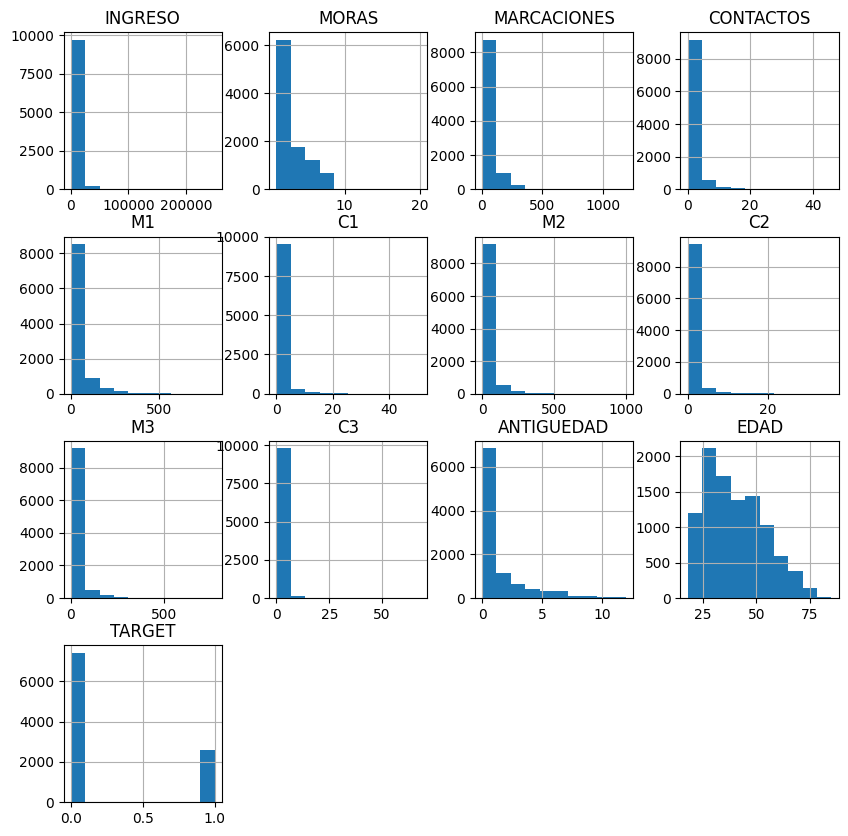

In [78]:
graficas.histograma_general(['columna_error','INGRESO', 'MORAS', 'MARCACIONES', 'CONTACTOS', 
            'M1', 'C1', 'M2', 'C2', 'M3', 'C3', 'ANTIGUEDAD', 'EDAD', 'TARGET'],10000)

### 6.1. Boxplot generales

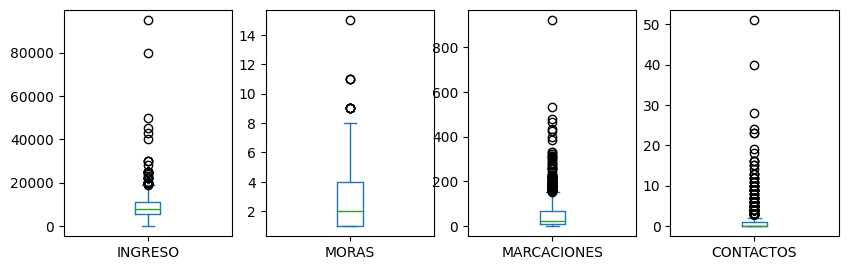

In [52]:
graficas.boxplot_general(['INGRESO', 'MORAS',  'MARCACIONES', 'CONTACTOS'],1000)

## 7. Crear un gráfico de barras especificos

Se puede crear un gráfico de barras que muestre la frecuencia de las categorías (discretas) y otro gráfico de barras que muestre la frecuencia de las variables continuas, histogramas mas detallados para obtener la frecuencia de las
categorías de los datos. Tanto numericas como no numericas**

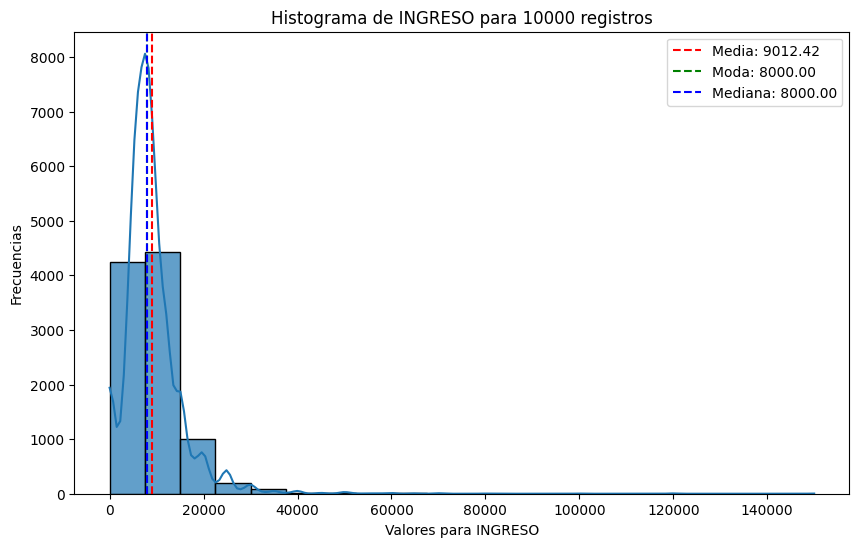

In [81]:
n = 10000
#graficas.histograma_frecuencia('INGRESO', n)
graficas.histograma_dinamico('INGRESO', n)

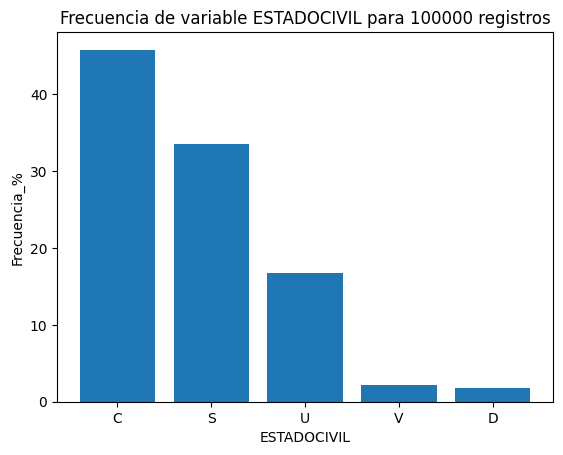

In [82]:
n = 100000
#graficas.histograma_frecuencia('MORAS', n)
graficas.histograma_dinamico( 'ESTADOCIVIL', n)

### 7.1 Otras graficas 

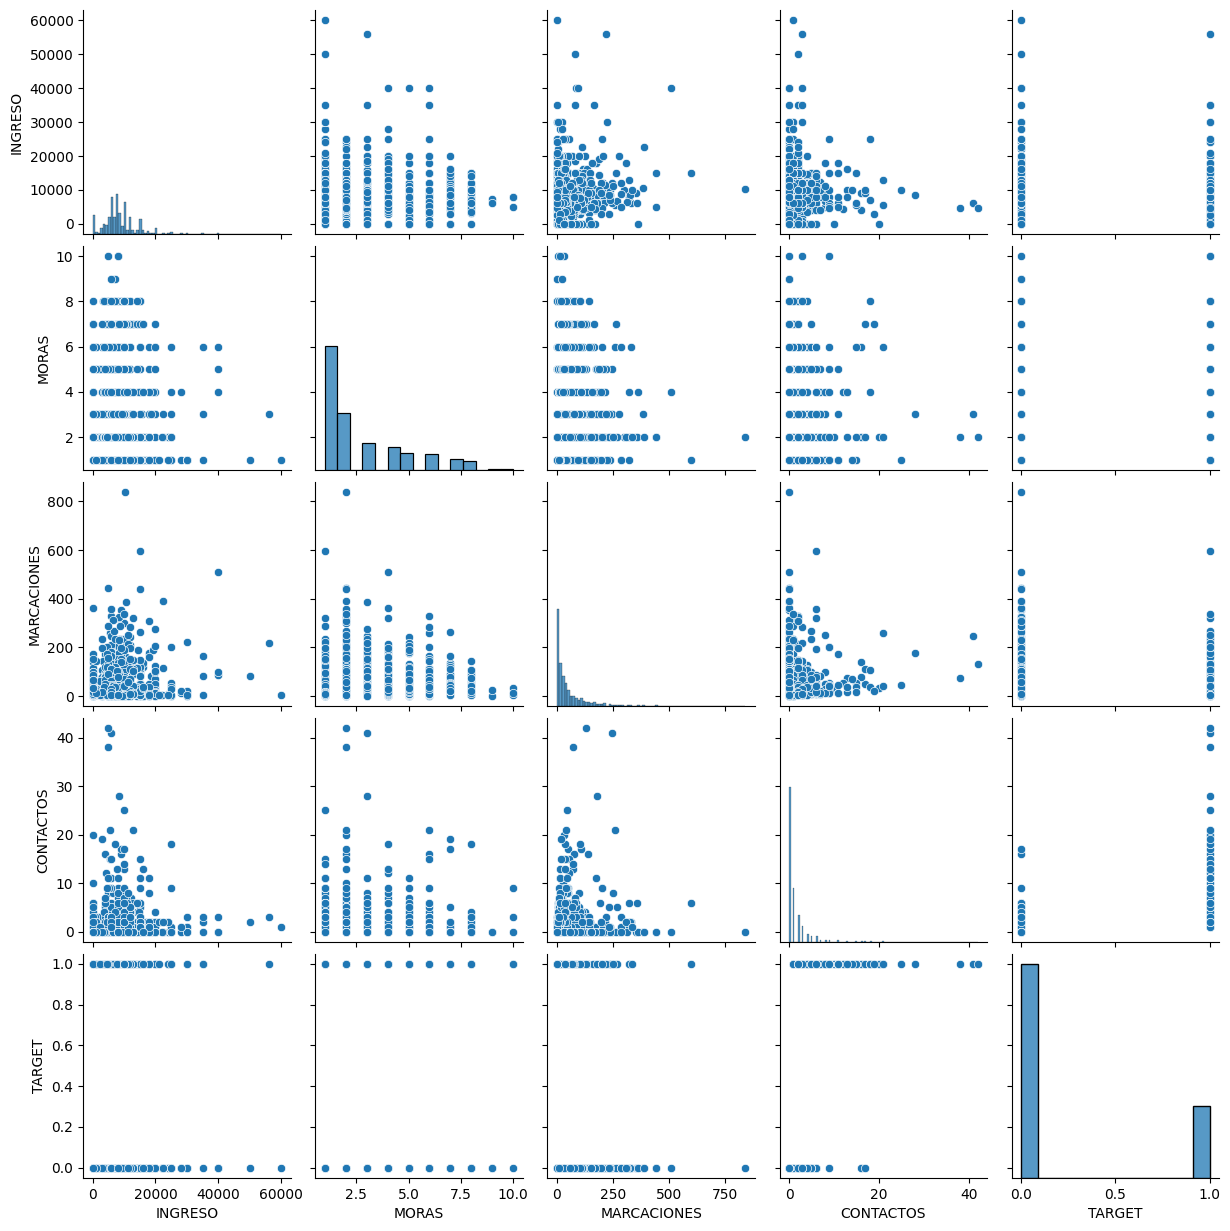

In [86]:
graficas.pairplot(['INGRESO', 'ESTADOCIVIL','MORAS', 'MARCACIONES', 'CONTACTOS', 'TARGET'],1000)

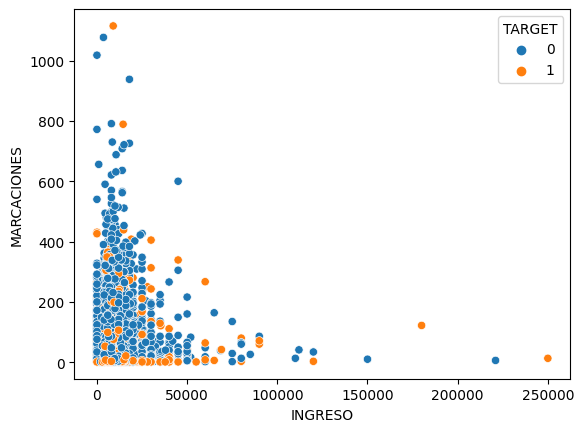

In [111]:
graficas.detalle_scatterplot('INGRESO','MARCACIONES',10000,'TARGET')

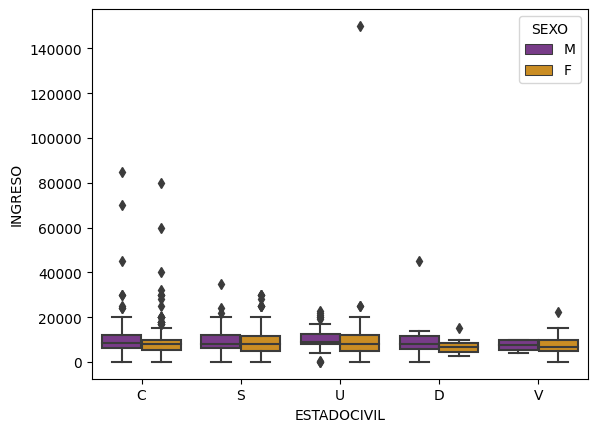

In [120]:
graficas.detalle_boxplot('INGRESO',1000, 'ESTADOCIVIL','SEXO')

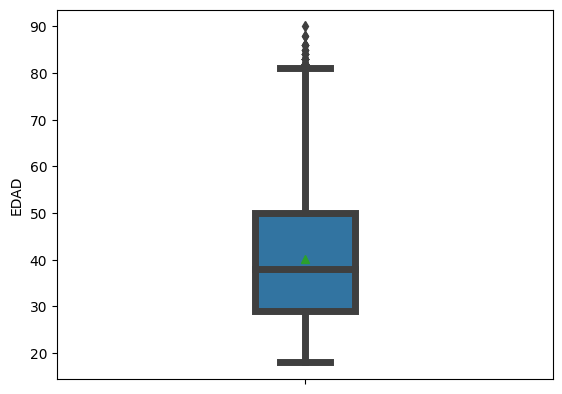

In [122]:
graficas.detalle_boxplot('EDAD',100000)

## 8. Analizar las correlaciones entre las variables

Se analiza las correlaciones entre las variables para identificar aquellas que sean linealmente dependientes.

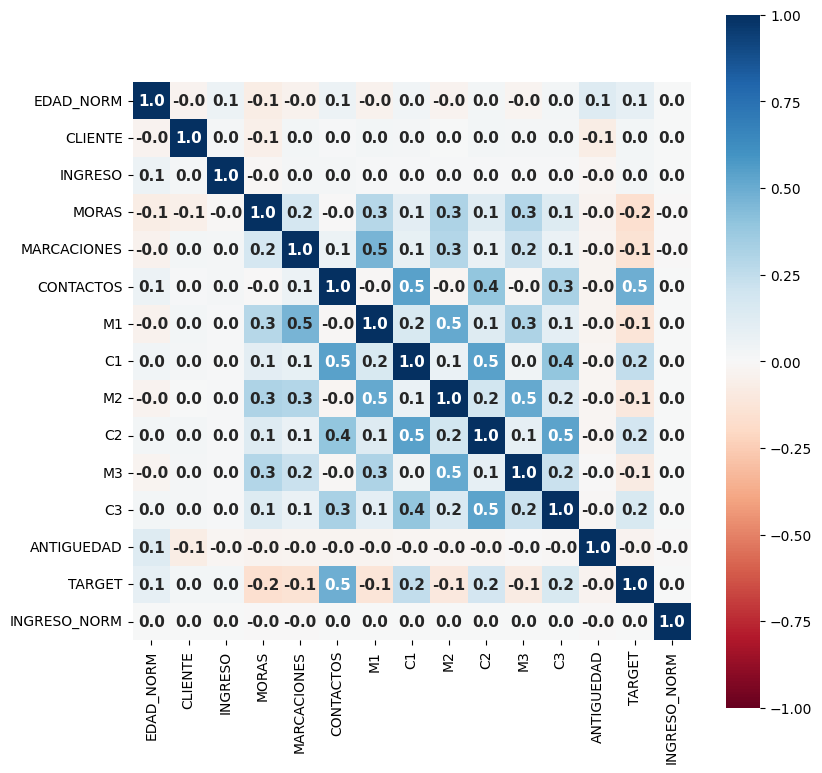

In [31]:
graficas.correlacion(list(revision.df.columns))

### 8.1 Criterio para interpretar la fuerza de la correlación

Dado que se está utilizando el coeficiente de correlación de Pearson (r), se puede utilizar el siguiente criterio para clasificar:

- Fuerte correlación positiva: r > 0.7
- Moderada correlación positiva: 0.3 < r < 0.7
- Débil correlación positiva: 0.1 < r < 0.3
- No correlación: -0.1 < r < 0.1
- Débil correlación negativa: -0.3 < r < -0.1
- Moderada correlación negativa: -0.7 < r < -0.3
- Fuerte correlación negativa: r < -0.7

In [11]:
def clasificacion_correlacion(matriz):
    signals = []
    for i in range(len(matriz)):
        for j in range(i+1, len(matriz)):
            signal_1 = matriz.columns[i]
            signal_2 = matriz.columns[j]
            correlation = matriz.iloc[i, j]
            classification = ""

            if correlation > 0.7:
                classification = "Fuerte correlación positiva"
            elif 0.3 < correlation <= 0.7:
                classification = "Moderada correlación positiva"
            elif 0.1 < correlation <= 0.3:
                classification = "Débil correlación positiva"
            elif -0.1 <= correlation <= 0.1:
                classification = "No correlación"
            elif -0.3 <= correlation < -0.1:
                classification = "Débil correlación negativa"
            elif -0.7 <= correlation < -0.3:
                classification = "Moderada correlación negativa"
            elif correlation < -0.7:
                classification = "Fuerte correlación negativa"

            signals.append([signal_1, signal_2, correlation, classification])

    df = pd.DataFrame(signals, columns=['sig_1', 'sig_2', 'nivel_correlacion', 'clasificacion'])
    return df

correlacion = revision.df.corr(method='pearson', numeric_only=True)
df_correlacion_clasificada = clasificacion_correlacion(correlacion)

print("Variables con Moderada correlación o mayor")
df_correlacion_clasificada[abs(df_correlacion_clasificada['nivel_correlacion']) >= 0.3].sort_values(by='nivel_correlacion', ascending=False)

Variables con Moderada correlación o mayor


,sig_1,sig_2,nivel_correlacion,clasificacion
15,MES,CLIENTE,0.708841,Fuerte correlación positiva
93,C1,C2,0.546740,Moderada correlación positiva
76,CONTACTOS,C1,0.541238,Moderada correlación positiva
106,C2,C3,0.531372,Moderada correlación positiva
85,M1,M2,0.513041,Moderada correlación positiva
100,M2,M3,0.510563,Moderada correlación positiva
83,CONTACTOS,TARGET,0.486836,Moderada correlación positiva
66,MARCACIONES,M1,0.464187,Moderada correlación positiva
78,CONTACTOS,C2,0.394086,Moderada correlación positiva
95,C1,C3,0.393286,Moderada correlación positiva


Conocer las correlaciones entre las características (features) en un problema de clasificación utilizando machine learning es importante por varias razones:

Reducción de dimensiones: Identificar características altamente correlacionadas puede ayudar a eliminar redundancias en los datos. Si dos características están altamente correlacionadas entre sí, significa que aportan información similar al modelo. En lugar de utilizar ambas características, se puede elegir una de ellas para reducir la dimensionalidad del conjunto de datos y evitar problemas de multicolinealidad.

Selección de características: La correlación entre las características y la variable objetivo (target) proporciona información sobre la relevancia de cada característica para el problema de clasificación. Características altamente correlacionadas con el target suelen tener un mayor impacto en el modelo y pueden ser consideradas como buenos predictores. Esto puede ayudar en la selección de características, ya que se pueden priorizar aquellas con una correlación más fuerte.

Interpretación de resultados: Comprender las correlaciones entre características puede brindar información sobre las relaciones internas dentro de los datos. Esto puede ayudar a interpretar los resultados del modelo y a comprender qué características son más influyentes en las predicciones.
s finales.

# Ingeniería de atributos/características

La ingeniería de características implica analizar los datos existentes y extraer información relevante que pueda ayudar a los algoritmos de aprendizaje automático a comprender mejor el problema y tomar decisiones más precisas. Esto puede incluir la creación de nuevas características a partir de las existentes, la normalización o escala de características, la codificación de variables categóricas, el manejo de valores faltantes, la reducción de dimensionalidad, entre otras técnicas.

## 9. Criterio para determinar los factores influyentes con respecto al objetivo

El proceso de determinar los factores influyentes con respecto al objetivo se conoce como "Selección de características" (Feature Selection) y se puede realizar de dos formas principalmente:

1. Utilizando métodos de filtro: En este enfoque, las características se clasifican según puntajes estadísticos que determinan su relación con la variable objetivo. Un método común es utilizar la correlación, que proporciona una primera aproximación. Sin embargo, también se puede utilizar el Valor de Información (IV) y el método de Chi-cuadrado para obtener diferentes perspectivas sobre las características.

2. Utilizando métodos de envoltura: En este enfoque, se emplean algoritmos de Machine Learning y se evalúa su rendimiento como criterio de selección de características. El objetivo es encontrar las características más adecuadas para el algoritmo, mejorando así su rendimiento. A medida que se iteran los modelos, se van tomando decisiones sobre la adición o eliminación de características del subconjunto. Este tipo de métodos suele ser computacionalmente exigente y se recomienda aplicarlo en muestras de datos.

Durante este proceso de verificación, también se realiza la preparación de los datos o preprocesamiento (feature engineering) para adaptar los datos a los modelos de machine learning que se utilizarán. Una de las variables que claramente no aporta información con respecto al objetivo es la columna "CLIENTE", por lo que se puede descartar esta columna en cualquier análalisis. 


In [180]:
revision.df = revision.df.drop(['CLIENTE'], axis=1)

Para poder utilizar la correlación y otros métodos de clasificación, es recomendable realizar la estandarización y normalización de los datos. Esto es un requisito común para muchos estimadores de Machine Learning, ya que los algoritmos pueden comportarse de manera deficiente si las características individuales no se parecen más o menos a datos estándar normalmente distribuidos. Para facilitar los cambios necesarios en el DataFrame, se crea la clase `Preprocesamiento`.

A continuación, se detalla la funcionalidad de cada uno de los métodos de la clase:

- `__init__(self, revisor_data)`: Constructor de la clase que recibe un objeto de la clase `RevisorDataCSV` como parámetro. Inicializa las variables `revisor_data`, `df`, `matriz_correlacion` y `transformaciones` con los valores correspondientes.

- `varibles_numericas(self)`: Devuelve una lista con las variables numéricas del DataFrame.

- `detecion_outlier(self, nombre_columna, q=0.1)`: Detecta los valores atípicos (outliers) de una columna específica utilizando cuantiles. Calcula los cuartiles, el rango intercuartílico y los límites inferior y superior para identificar los outliers. Devuelve una lista con los índices de los valores atípicos.

- `eliminacion_outlier(self, nombre_columna, q=0.1)`: Elimina los valores atípicos (outliers) de una columna específica utilizando cuantiles. Los cambios se aplican directamente al DataFrame.

- `guardar_transformador(self, nombre_columna, transformador)`: Guarda un transformador aplicado a una columna en un diccionario. Si ya existe un transformador para esa columna, se agrega al final de la lista de transformadores.

- `Transf_MinMaxScaler(self, nombre_columna)`: Crea un objeto que transforma los valores de una columna utilizando el escalador `MinMaxScaler` de scikit-learn. Devuelve el objeto escalador para transformar futuros valores.

- `Transf_Quantile(self, nombre_columna)`: Crea un objeto para transformar los valores de una columna utilizando el transformador `QuantileTransformer` de scikit-learn.

- `Transf_OneHot_binario(self, nombre_columna)`: Crea un objeto para realizar la transformación One-Hot cuando la variable es binaria. Devuelve el transformador ya entrenado.

- `Transf_OneHot(self, nombre_columna)`: Crea un objeto para transformar los valores de una columna utilizando el codificador `OneHotEncoder` de scikit-learn.

- `Transf_woe(self, nombre_columna, nombre_target)`: Crea un objeto para transformar los valores de una columna utilizando el Weight of Evidence (WOE) de OptimalBinning. Este método distingue entre variables numéricas y categóricas y devuelve el objeto transformador correspondiente.

- `calc_matriz_correlacion(self, columnas=None, filas=None)`: Método para la creación de la matriz de correlación. Permite especificar el número de filas y columnas a considerar para el cálculo de la correlación. Calcula la matriz de correlación utilizando el método de correlación de Pearson y la almacena en la variable `matriz_correlacion`.

- `clasificacion_correlacion(self, target_name, nivel_correlacion_target=0.3, nivel_correlacion_inter_variables=0.3)`: Clasifica las variables en función del nivel de correlación. Identifica las variables con una correlación moderada con el objetivo (target) y las variables con correlación moderada entre ellas para reducir la multicolinealidad. Devuelve una lista de las variables seleccionadas.

- `crea_EDAD_NORM(self, nombre_columna='EDAD')`: Este método crea una variable llamada "EDAD" normalizada. Utiliza la fecha actual como referencia y calcula la diferencia entre la fecha de nacimiento proporcionada y la fecha actual. Luego, aplica una eliminación de outliers y una transformación estándar, normalizando los valores entre el valor mínimo y máximo. Utiliza el objeto `Transf_MinMaxScaler` para realizar la transformación y guarda el objeto transformador para su uso posterior. Finalmente, elimina las columnas 'ANIO', 'MES' y 'FECHANACIMIENTO' del DataFrame.

- `mod_columna_Transf_Quantile(self, nombre_columna)`: Este método modifica la columna indicada utilizando `Transf_Quantile`. Aplica la transformación de cuantiles a la columna, utilizando el objeto `Transf_Quantile`, y guarda el objeto transformador para su uso posterior.

- `mod_columna_OneHot_binario(self, nombre_columna)`: Este método modifica la columna indicada utilizando la codificación One-Hot binaria. Utiliza el objeto `Transf_OneHot_binario` para realizar la codificación. Convierte la columna en un arreglo binario y reemplaza la columna original en el DataFrame por las columnas codificadas. Guarda el objeto transformador para su uso posterior.

- `mod_columna_OneHot(self, nombre_columna)`: Este método modifica la columna indicada utilizando la codificación One-Hot. Utiliza el objeto `Transf_OneHot` para realizar la codificación. Convierte la columna en un arreglo de variables binarias y agrega estas columnas al DataFrame. Luego, elimina la columna original del DataFrame. Guarda el objeto transformador para su uso posterior.

- `mod_woe(self, nombre_columna, nombre_target, metrica="woe")`: Este método transforma los elementos de una columna utilizando la técnica Weight of Evidence (WOE) de OptimalBinning. El WOE se utiliza para medir la relación entre una variable predictora y una variable objetivo. Se puede especificar la métrica a utilizar, que puede ser "event_rate", "woe", "indices" o "bins". Utiliza el objeto `Transf_woe` para realizar la transformación. Calcula el WOE de la columna indicada en relación con la variable objetivo especificada. Reemplaza los valores de la columna con los valores WOE calculados. Guarda el objeto transformador para su uso posterior.

Estos métodos realizan diferentes transformaciones en las columnas del DataFrame utilizando diversas técnicas de transformación o codificación. También guardan los objetos transformadores utilizados, lo que permite aplicar las mismas transformaciones a nuevos datos en el futuro.


In [7]:
class preprocesamiento:
    def __init__(self,revisor_data):
        """
        Constructor de la clase recibe el objeto instanciado de la clase revisor_data_csv, 
        seria mejor usar un patron de diseño DataFrameSingleton pero esta division solo es 
        para fines demostrativos,en codigo final todos los metodos deben 
        pertenecer a una sola clase.
        """
        try:
            # Se carga el df 
            self.revisor_data = revisor_data
            self.df = self.revisor_data.df
            self.matriz_correlacion = None
            self.transformaciones = {}
        except Exception as error:
            print("Ocurrió un error:", error)

    #Este metodo esta repetido en la clase graficos, al final se debe mejorar el codigo ya sea uniendo todas las clases o usando herencias.
    def varibles_numericas(self):
        """Devuelve una lista con las variables numericas de un df"""
        return [column_name for column_name, data_type in zip(self.df.columns, self.df.dtypes) if ((data_type != 'category') and  np.issubdtype(data_type, np.number))]
    
    def detecion_outlier(self,nombre_columna,q=.1):
        """ 
        Funcion para detectar valores atípicos (utiliers) de una columna especifica usando cuantiles.
        Por defecto se usa Deciles / dividiendo la distribucion en 10 partes, pero ajsutando el valor de
          q = 0.25 se trabajaria con cuartiles.
        La funcion devuelve una "lista/pandas.core.indexes.numeric.Int64Index"  con los indices de los 
        valores atípicos del df
        """
        # try:
        #calculo de cuantiles
        Q1 = self.df[nombre_columna].quantile(q)
        Q3 = self.df[nombre_columna].quantile(1-q)
        IQR = Q3-Q1
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR
        indice_filas_eliminar = self.df.index[(self.df[nombre_columna] < limite_inferior) | (self.df[nombre_columna] > limite_superior) ]
        return indice_filas_eliminar   

    def eliminacion_outlier(self,nombre_columna,q=0.1):
        """ 
        Funcion para eliminar valores atípicos (outliers) de una columna especifica usando cuantiles.
        La funcion no devuelve nada porque los cambios se hacen en el df que se pasa por referencia
        """
        try:
            if nombre_columna in self.varibles_numericas():
                indices = self.detecion_outlier(nombre_columna,q)
                self.df = self.df.drop(indices)
                self.df.reset_index(inplace=True,drop=True)
            else:
                print("La variable no es numerica")
        except Exception as error:
            print("Ocurrió un error:", error)
            
    def guardar_transformador(self,nombre_columna,transformador):
        """Metodo para guardar transformador aplicado, se almacenan en lista, si se
        aplican dos o mas se almacenaran en la secuencia aplicada"""
        if nombre_columna in list(self.transformaciones.keys()):
            self.transformaciones[nombre_columna] = self.transformaciones[nombre_columna]+[transformador]
        else:
            self.transformaciones[nombre_columna] = [transformador]
            
    def Transf_MinMaxScaler(self,nombre_columna):
        """crea objeto que Transforma los valores de la columna indicada 
        usando MinMaxScaler de sklear, devuelve el objeto para transformar futuros valores"""
        try:
            if nombre_columna in self.varibles_numericas():
                scaler = preprocessing.MinMaxScaler()
                escalador = scaler.fit(self.df[nombre_columna].values.reshape(-1, 1))
                return escalador
            else:
                print("La variable no es numerica")
        except Exception as error:
            print("Ocurrió un error:", error)

    def Transf_Quantile(self,nombre_columna):
        """crea objeto para Transformar los valores de la columna indicada  
        usando  QuantileTransformer de sklearn"""
        try:
            if nombre_columna in self.varibles_numericas():
                scaler = preprocessing. QuantileTransformer()
                escalador = scaler.fit(self.df[nombre_columna].values.reshape(-1, 1))
                return escalador
            else:
                print("La variable no es numerica")
        except Exception as error:
            print("Ocurrió un error:", error)   

    def Transf_OneHot_binario(self, nombre_columna):
        """Crea objeto para transformacion  OneHot cuando la varible es binaria, devuelve
        el transformador ya entrenado"""
        try:
            value_var = self.df[nombre_columna].astype("category")
            codificador_oneHot = OneHotEncoder(handle_unknown='ignore', drop='first')
            codificacion = codificador_oneHot.fit(pd.DataFrame(value_var, columns=[nombre_columna]))
            return codificacion
        except Exception as error:
            print("Ocurrió un error:", error)

    def Transf_OneHot(self, nombre_columna):
        """crea objeto para Transformar los valores de la columna indicada  
        usando  OneHot encoder de sklearn, devuelve el transformador entrenado """
        try:
            value_var = self.df[nombre_columna].astype("category")
            codificador_oneHot = OneHotEncoder(handle_unknown='ignore')
            codificacion = codificador_oneHot.fit(pd.DataFrame(value_var, columns=[nombre_columna]))
            return codificacion
        except Exception as error:
            print("Ocurrió un error:", error)

    def Transf_woe(self,nombre_columna,nombre_target):
        """crea el objeto para Transformar los valores de la columna indicada  
        usando woe de OptimalBinning,
        Distinge de variables numericas y categoricas
        Devuelve el objeto transoformador"""
        try:
            data_type = self.df[nombre_columna].dtypes
            target = self.df[nombre_target]
            x = self.df.loc[:,nombre_columna]
            if (data_type == 'object' or data_type.name == 'category'):  
                optb = OptimalBinning(name = nombre_columna,dtype ='categorical',solver='mip')
                optb.fit(x,target)
            elif np.issubdtype(data_type, np.number):
                optb = OptimalBinning(name = nombre_columna,dtype = 'numerical',solver='cp')
                optb.fit(x,target)
            else:
                print("La variable se de convertir a tipo numerica o categorica")
                optb = None
                
            return optb
        except Exception as error:
            print("Ocurrió un error:", error)        

    def calc_matriz_correlacion(self, columnas=None,filas=None):
        """metodo para la creacion de la matriz de correlacion, se pude ajustar el numero de filas y las columnas
        a calcular para la correlacion"""
        try:
            if self.matriz_correlacion is None or self.matriz_correlacion.empty:
                if columnas:
                    # Se confirma que las columnas existan y sean numericas
                    columnas = [ col for col in columnas if col in self.varibles_numericas()]
                else:
                    columnas = self.varibles_numericas()
                if filas:
                    data_set = self.df[columnas].sample(filas)
                    data_set.reset_index(inplace=True,drop=True)
                else:
                    data_set = self.df[columnas]
                self.matriz_correlacion = data_set.corr(method='pearson', numeric_only=True)
        except Exception as error:
            print("Ocurrió un error:", error)    

    def clasificacion_correlacion(self, target_name ,nivel_correlacion_target = 0.3, nivel_correlacion_inter_variables = 0.3):
        """Metodo para clasificar las variables en funcion del nivel de correlacion 
        1. Entre las variables y el objetivo (target_name), escogiendo las que tengan una 
        Moderada correlación |corr| > 0.3 pero se puede ajustar si se desea.
        2. Entre las mismas variables permitiendo hasta una Moderada correlación |corr| < 0.3  entre ellas
        con el objetivo de reducir la multicolinalidad"""

        try:
            # Calculo de la correlacion para todas las variables
            self.calc_matriz_correlacion()
            matriz = self.matriz_correlacion

            #Verificacion de la correlacion entre todas las variables y el target, ordenadas de mayor a menor
            signals = []
            for i in range(len(matriz)):
                for j in range(i+1, len(matriz)):
                    signal_1 = matriz.columns[i]
                    signal_2 = matriz.columns[j]
                    correlation = abs(matriz.iloc[i, j])
                    signals.append([signal_1, signal_2, correlation])
            df_correlacion = pd.DataFrame(signals, columns=['sig_1', 'sig_2', 'nivel_correlacion'])
            df_correlacion_mod = df_correlacion[df_correlacion['sig_2'] == target_name].sort_values(by='nivel_correlacion', ascending=False)
            variables_x = list(df_correlacion_mod [df_correlacion_mod['nivel_correlacion']>nivel_correlacion_target]['sig_1'])

            # Verificacion de la correlacion entre variables 
            for i, variable1 in enumerate(variables_x):
                for variable2 in variables_x[i+1:]:
                    mask = (df_correlacion['sig_1'] == variable1) & (df_correlacion['sig_2'] == variable2)
                    val_corr = list(df_correlacion[mask]['nivel_correlacion'])
                    if not val_corr:
                        mask = (df_correlacion['sig_1'] == variable2) & (df_correlacion['sig_2'] == variable1)
                        val_corr = list(df_correlacion[mask]['nivel_correlacion'])
                    val_corr = val_corr[0] if val_corr else 0
                    if val_corr > nivel_correlacion_inter_variables:
                        if variable2 in variables_x:
                            variables_x.remove(variable2)
            return variables_x
        except Exception as error:
            print("Ocurrió un error:", error)

    
    def crea_EDAD_NORM(self,nombre_columna = 'EDAD'):
        """Para crear una variable EDAD normalizada se usa como referencia la fecha actual,
        independiente del momento en que se corra el programa, se calcula la diferencia entre
        la fecha de nacimiento provista y la fecha actual, se aplica una eliminacion de outliers
        y una transformacion estandar normalizando entre el valor minimo y maximo.
        """
        try:
            fecha_actual = datetime.datetime.now()
            self.df[nombre_columna] = (fecha_actual - self.df['FECHANACIMIENTO']).dt.days // 365
            self.eliminacion_outlier(nombre_columna)
            escalador = self.Transf_MinMaxScaler(nombre_columna) 
            self.df[nombre_columna] = escalador.transform(self.df[nombre_columna].values.reshape(-1, 1)) 
            self.guardar_transformador(nombre_columna,escalador)
            self.df.drop(columns=['ANIO', 'MES','FECHANACIMIENTO'], inplace=True)
        
            # Se actualiza la instancia de la clase revisor_data_csv
            #self.revisor_data.df = self.df
        except Exception as error:
            print("Ocurrió un error:", error)

    def mod_columna_Transf_Quantile(self,nombre_columna):
        """Modifica la columna indicada utilizando el Transf_Quantile, 
        alamcena el nombre de la columna modificada y el objeto utilizado para la transformacion"""
        try:
            escalador = self.Transf_Quantile(nombre_columna)
            self.df[nombre_columna] = escalador.transform(self.df[nombre_columna].values.reshape(-1, 1))
            self.guardar_transformador(nombre_columna,escalador)
            
            # Se actualiza la instancia de la clase revisor_data_csv
            #self.revisor_data.df = self.df
        except Exception as error:
            print("Ocurrió un error:", error)

    def mod_columna_OneHot_binario(self,nombre_columna):
        """Modifica la columna indicada utilizando OneHot_binario, 
        almacena el nombre de la columna modificada y 
        el objeto utilizado para la transformacion"""
        try:
            escalador = self.Transf_OneHot_binario(nombre_columna)
            arreglo = escalador.transform(preproceso.df[[nombre_columna]]).toarray()
            self.df[nombre_columna] = arreglo.astype(int)
            self.guardar_transformador(nombre_columna,escalador)
    
             # Se actualiza la instancia de la clase revisor_data_csv
            #self.revisor_data.df = self.df
        except Exception as error:
            print("Ocurrió un error:", error)

    def mod_columna_OneHot(self,nombre_columna):
        try:
            escalador = self.Transf_OneHot(nombre_columna)
            arreglo = escalador.transform(preproceso.df[[nombre_columna]]).toarray()
            columnas_codificadas = escalador.get_feature_names_out([nombre_columna])
            df_codificado = pd.DataFrame(arreglo, columns=columnas_codificadas)

            #Se introducen en df los valores codificados
            pos = self.df.columns.get_loc(nombre_columna)
            for col in df_codificado.columns:
                self.df.insert(pos, col, df_codificado[col])
                pos += 1
            self.df.drop(columns=[nombre_columna], inplace=True)
            self.guardar_transformador(nombre_columna,escalador)
            
             # Se actualiza la instancia de la clase revisor_data_csv
            #self.revisor_data.df = self.df
        except Exception as error:
            print("Ocurrió un error:", error)
        
    def mod_woe(self,nombre_columna,nombre_target,metrica = "woe"):
        """Metodo para transformar los elementos de una columna 
        usando woe de OptimalBinning, se pueden utilizar otras metricas 
        como: "event_rate", "woe", "indices" and "bins" ."""
        try:
            escalador = self.Transf_woe(nombre_columna,nombre_target)
            x = self.df.loc[:,nombre_columna]
            self.df[nombre_columna] = escalador.transform(x, metric=metrica)
            self.guardar_transformador(nombre_columna,escalador)

             # Se actualiza la instancia de la clase revisor_data_csv
            #self.revisor_data.df = self.df
        except Exception as error:
            print("Ocurrió un error:", error)  

In [8]:
preproceso = preprocesamiento(revision)

Cada columna o variable tiene caracteristicas que debe ser analizada para hacer la transformacion mas adecuada, en este caso se pueden distiguir las siguientes:

* La variable 'EDAD' registra la edad del cliente al momento del registro, clasificándola como una variable cuantitativa de intervalo. Esta variable está relacionada con 'ANIO', 'MES' y 'FECHANACIMIENTO'. Con el objetivo de simplificar y capturar la información de las edades de los clientes, proponemos convertir la variable 'EDAD' en una variable cuantitativa de razón. Para lograr esto, utilizaremos el tiempo actual como referencia para calcular la edad y normalizaremos los valores, preservando únicamente la información relativa a las edades de los clientes.
  
* La variable 'INGRESO' presenta una significativa cantidad de outliers, sin emabrgo no se deben eliminar porque en realidad respresentan informacion valida,
por eso se procede a normalizar utiliando intercuartiles, ya que esta normalizacion disminuye el impacto de los outliers.
* Las variables 'SEXO' y 'ESTADOCIVIL' se pueden codificar usando OneHotEncoder de sklearn.

* El resto de las variables se puede normalizar usando diferentes metodos, sin embargo por simplicidad se utilizara el weight of evidence apoyandonos en la libreria OptimalBinning

In [9]:
preproceso.crea_EDAD_NORM('EDAD')
preproceso.mod_columna_Transf_Quantile('INGRESO')
preproceso.mod_columna_OneHot_binario('SEXO')
preproceso.mod_columna_OneHot('ESTADOCIVIL')
preproceso.mod_woe('ESTADO','TARGET')

columnas_faltantes = ['MORAS', 'MARCACIONES', 'CONTACTOS', 'M1', 'C1', 'M2', 'C2','M3', 'C3', 'ANTIGUEDAD']
for columna in columnas_faltantes:
    preproceso.mod_woe(columna,'TARGET')

In [4]:
#Para utilizar las graficas se debe instanciar la clase con el nuevo df
graficas = revisor_grafico(revision.df)

Una vez que se tienen las variables normalizadas y ajustadas para su implementacion en los modelos se pueden escoger varios metodos para hacer la seleccion de las variables mas importantes.

### 9.1 Filtro: Correlacion para Seleccion de factores influyentes

In [134]:
# utilizando la correlacion como indicador
variables_a_utilizar = preproceso.clasificacion_correlacion('TARGET')
variables_a_utilizar = variables_a_utilizar+['TARGET']
print("Permitiendo una correlacion minima de 0.3 variables/target e intervariables las columnas a usar son  :\n",variables_a_utilizar)

Permitiendo una correlacion minima de 0.3 variables/target e intervariables las columnas a usar son  :
 ['CONTACTOS', 'MARCACIONES', 'TARGET']


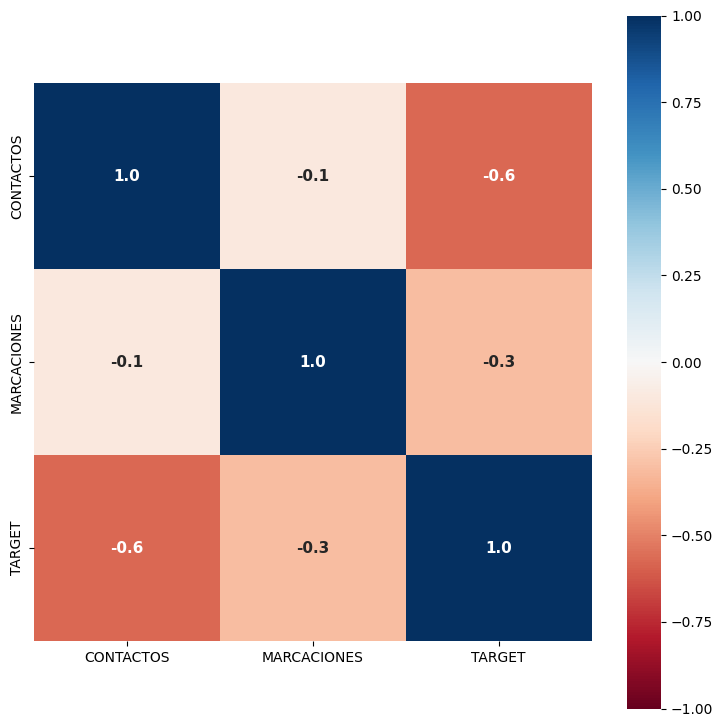

In [6]:
graficas.correlacion(variables_a_utilizar)

In [136]:
# Correlacion dejando mas libertad 
min_corr_target = 0.2
max_corr_inter = 0.5
variables_a_utilizar = preproceso.clasificacion_correlacion('TARGET',min_corr_target,max_corr_inter)
variables_a_utilizar = variables_a_utilizar+['TARGET']
print(f"Permitiendo una correlacion minima de {min_corr_target} variables/target y max {max_corr_inter} intervariables las columnas a usar son  :\n",variables_a_utilizar)

Permitiendo una correlacion minima de 0.2 variables/target y max 0.5 intervariables las columnas a usar son  :
 ['CONTACTOS', 'MARCACIONES', 'C1', 'C2', 'TARGET']


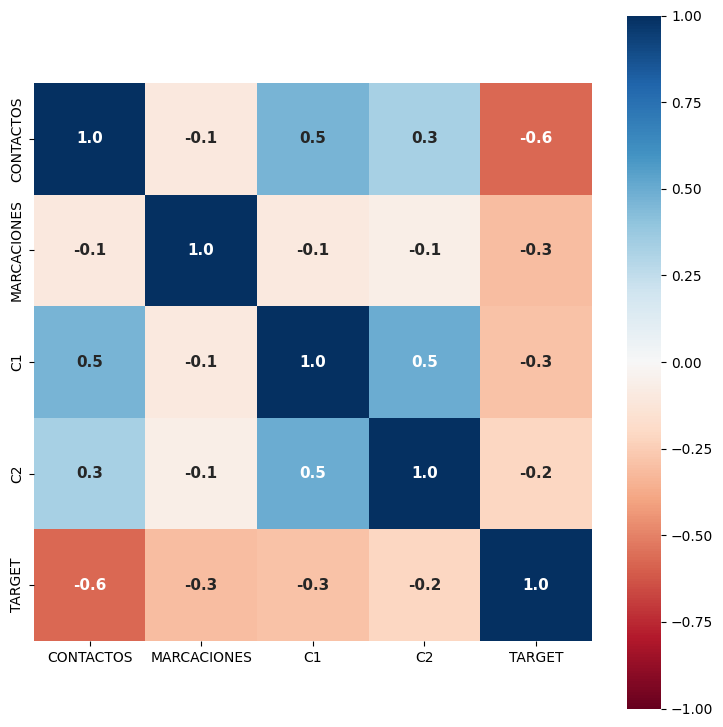

In [8]:
graficas.correlacion(variables_a_utilizar)

### 9.2 Filtro: Information Value (IV) para Seleccion de factores influyentes

El Information Value (IV) es una medida para evaluar la capacidad predictiva de una variable en relación con la variable objetivo. Se calcula analizando la distribución de la variable en diferentes categorías y su relación con la variable objetivo. El IV se utiliza como criterio para seleccionar características relevantes. Se busca un IV alto (por encima de un umbral) para considerar una variable como informativa. Esto ayuda a simplificar y mejorar la precisión del modelo al reducir el ruido y la redundancia en los datos.

El IV cuantifica la predictividad de una variable de la siguiente manera:
- IV < 0.02: Variable sin poder predictivo.
- 0.02 ≤ IV < 0.1: Variable con un poder predictivo débil.
- 0.1 ≤ IV < 0.3: Variable con un poder predictivo medio.
- 0.3 ≤ IV < 0.5: Variable con un poder predictivo fuerte.
- IV ≥ 0.5: Variable con un poder predictivo muy fuerte.

In [100]:
#En esta caso se pueden convertir todas las varibles usando woe
preproceso_woe = preprocesamiento(revision)

#Se modifica primero edad usando MinMaxScaler
preproceso_woe.crea_EDAD_NORM('EDAD')

#Se aplica woe a todas las variables (menos a target)
for columna in preproceso_woe.df.drop(columns = ['TARGET']):
     preproceso_woe.mod_woe(columna,'TARGET')
    
# Se puede visualizar la informacion en el proceso de transformacion
tablas_transformacion = {}
for nombre_columna , transformador in zip(preproceso_woe.transformaciones.keys(), preproceso_woe.transformaciones.values())      :
    tablas_transformacion[nombre_columna] = transformador[-1].binning_table.build()

# O tambien obtener la informacion necesaria directamente
def  encontrarIV(preproceso_obj):
    nombre_Columnas = []
    columnas_IV = []
    columnas_gini = []
    columnas_JS = []
    for nombre_columna , transformador in zip(preproceso_obj.transformaciones.keys(), preproceso_obj.transformaciones.values())      :
        nombre_Columnas.append(nombre_columna)
        columnas_IV.append(transformador[-1].binning_table.iv)
        columnas_gini.append(transformador[-1].binning_table.gini)
        columnas_JS.append(transformador[-1].binning_table.js)
        
    df_Information_values = pd.DataFrame({'Feature': nombre_Columnas,'IV' :columnas_IV,'gini':columnas_gini,'JS':columnas_JS} )
    df_Information_values.sort_values(by='IV', ascending=False,inplace=True)
    df_Information_values.reset_index(inplace=True,drop=True)
    return df_Information_values

df_Information_values = encontrarIV(preproceso_woe)

print(f"filtrando para variables con valor predictivo mayor a moderado (IV>0.3) las columnas a usar son  :\n")
print(df_Information_values[df_Information_values['IV']>0.3])


filtrando para variables con valor predictivo mayor a moderado (IV>0.3) las columnas a usar son  :

       Feature        IV      gini        JS
0    CONTACTOS  1.694075  0.582097  0.182586
1  MARCACIONES  0.462279  0.335012  0.053102
2           C1  0.391705  0.286734  0.046200


### 9.3 Filtro: SelectKBest Chi-cuadrado para Seleccion de factores influyentes

SelectKBest es una clase de la biblioteca scikit-learn que se utiliza para seleccionar las mejores características según una función de puntuación dada. En este caso, se utiliza la función de puntuación chi2, que calcula el estadístico chi-cuadrado para evaluar la dependencia entre dos variables categóricas. Cuanto mayor sea la puntuación chi-cuadrado, mayor será la dependencia entre la característica y la variable objetivo. SelectKBest selecciona las k características con las puntuaciones chi-cuadrado más altas.

Este código realiza transformaciones en los datos utilizando la métrica event_rate, aplica la transformación a las variables, utiliza SelectKBest con chi2 como función de puntuación para seleccionar las mejores características y muestra los resultados en un DataFrame.

In [3]:
#   esto porque chi2 no permite valores negativos
preproceso_chi2 = preprocesamiento(revision)

#Se modifica primero edad usando MinMaxScaler
preproceso_chi2.crea_EDAD_NORM('EDAD')

#Se aplica woe a todas las variables (menos a target)
for columna in preproceso_chi2.df.columns[:-1]:
     preproceso_chi2.mod_woe(columna,'TARGET','event_rate')

x = preproceso_chi2.df.iloc[:,:-1]
y = preproceso_chi2.df[['TARGET']]

prueba = SelectKBest(score_func=chi2,k = 5)
entrenamiento = prueba.fit(x,y)

x_final =  prueba.transform(x)

df_SelectKBest = pd.DataFrame({'Feature': x.columns ,'kBest_chi2' :entrenamiento.scores_} )
df_SelectKBest.sort_values(by='kBest_chi2', ascending=False,inplace=True)
df_SelectKBest.reset_index(inplace=True,drop=True)
df_SelectKBest.head()

#caracteristicas = entrenamiento.transform(x)

,Feature,kBest_chi2
0,CONTACTOS,7945.805251
1,MARCACIONES,699.555893
2,C1,523.399643
3,C2,155.959107
4,M1,90.524811


### 9.4 Filtro:  Análisis de Componentes Principales (PCA) 

El Análisis de Componentes Principales (PCA, por sus siglas en inglés) es una técnica de reducción de dimensionalidad que se utiliza para identificar patrones y estructuras subyacentes en conjuntos de datos de alta dimensionalidad. El objetivo del PCA es transformar un conjunto de variables correlacionadas en un nuevo conjunto de variables no correlacionadas llamadas componentes principales usando la Descomposición de Valor Singular (SVD) de los datos para proyectarlos a un espacio dimensional más bajo. Los datos de entrada se centran pero no se escalan para cada característica antes de aplicar el SVD.

La implementación del PCA utilizando la biblioteca scikit-learn en Python se realiza a través del módulo sklearn.decomposition y la clase .Po de los componentes principales.

El PCA permite reducir la dimensionalidad de los datos al seleccionar un número adecuado de componentes principales que capturan la mayor parte de la varianza. Estos componentes principales se pueden utilizar posteriormente en tareas de análisis exploratorio, visualización de datos o como entrada para alg

La desventaja de este metodo es que se pierde la relacion entre la data y los resultados de cualqueir modelo.oritmos de aprendizaje automático.A.

varianza_explicada: [0.23349505 0.16387174]


Text(0, 0.5, 'Componente secundario')

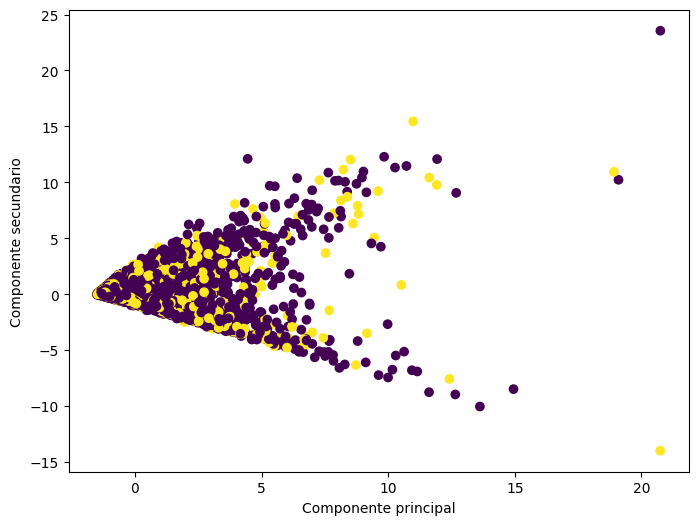

In [53]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


preproceso = preprocesamiento(revision)
preproceso.df = preproceso.df.sample(10000)

# Se convierten todas las variables 
preproceso.crea_EDAD_NORM('EDAD')

# para variar un poco se ustilizara la conversion mas sencilla 
# en las variables categoricas
preproceso.mod_columna_OneHot('ESTADO')
preproceso.mod_columna_OneHot('ESTADOCIVIL')
preproceso.mod_columna_OneHot_binario('SEXO')
preproceso.mod_columna_Transf_Quantile('INGRESO')

#Tambien se pueden utilizar otras formas de normalizar
def trans_StandardScaler(df_org,columnas):
    df = df_org[columnas]
    escalador = StandardScaler()
    escalador.fit(df)
    data_transf = escalador.transform(df)
    df_trans = pd.DataFrame (revisar,columns = otras_columnas)
    for columna in df_trans.columns:
        df_org[columna] = df_trans[columna]
    return df_org
otras_columnas = ['MORAS','MARCACIONES', 'CONTACTOS', 'M1', 'C1', 'M2', 'C2','M3', 'C3', 'ANTIGUEDAD']
preproceso.df = trans_StandardScaler(preproceso.df,otras_columnas)



#Se define la cantidad componentes a utilizar
k = 2
# Crearmos instancia de la clase `PCA`:
pca = PCA(n_components=k)

X = preproceso.df.drop(columns = ['TARGET'])
y = preproceso.df['TARGET'].to_numpy()

pca.fit(X)

componentes_principales = pca.components_
varianza_explicada = pca.explained_variance_ratio_

X_transformado = pca.transform(X)

print('varianza_explicada:',varianza_explicada)

plt.figure(figsize= (8,6))
plt.scatter(X_transformado[:,0],X_transformado[:,1],c = y)
plt.xlabel('Componente principal')
plt.ylabel('Componente secundario')

### 9.5: Envoltura: Feature Importance Tree Classifier
Se puede obtener la importancia de la característica de cada variable/columna del conjunto de datos utilizando la propiedad de importancia de la característica del modelo.
La importancia de las características es una clase incorporada que viene con los clasificadores basados en árboles, usaremos el `ExtraTreesClassifier` para extraer las 5 características principales para el conjunto de datost
En el caso del clasificador `ExtraTreesClassifier` de scikit-learn, la importancia de las características se calcula por defecto mediante la medida "Gini importance" pero se puede modifica para que utilice `{“gini”, “entropy”, “log_loss”}`. Esta métrica mide la reducción media de la impureza de Gini que se logra al dividir un nodo utilizando una característica en particular en el árbol de decisión.prueba de dimensiones `(n_samples, n_features)`.

La implementación interna de `ExtraTreesClassifier` se basa en la construcción y entrenamiento de múltiples árboles de decisión utilizando una combinación de Bootstrap Aggregating (Bagging) y selección aleatoria de características. Cada árbol se entrena utilizando una versión modificada del algoritmo de árboles de d isión CART (Classification and Regression Trees).

El proceso de selección de características aleatorias implica seleccionar un subconjunto aleatorio de características en cada nodo de división durante la construcción de los árboles. La importancia de cada característica se calcula utilizando la métrica de importancia Gini o Entropía de cada árbol, y luego se promedia para otener una importancia global de las características.

La predicción se realiza tomando las decisiones de cada árbol individual en el conjunto y realizando ullevar a un mejor rendimiento en la clasificación de datos.

Las 5 columnas mas importantes y su nivel de importancia es:
 CONTACTOS :	 0.3
 MARCACIONES :	 0.15
 EDAD :	 0.08
 ESTADO :	 0.08
 INGRESO :	 0.07


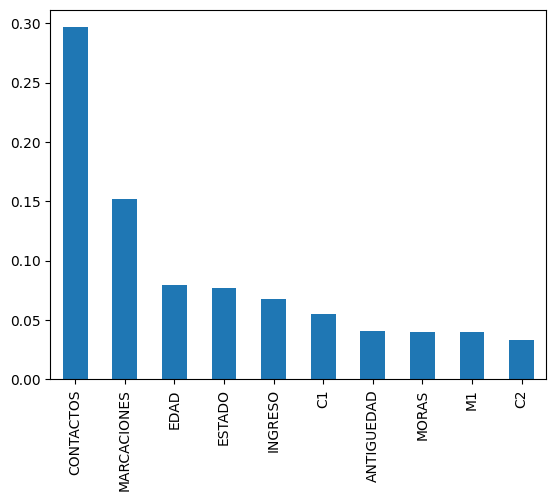

In [130]:
from sklearn.ensemble import ExtraTreesClassifier

preproceso = preprocesamiento(revision)

# Para este caso solo se convertira la edad
preproceso.crea_EDAD_NORM('EDAD')

#Se aplica woe a todas las variables (menos a target)
for columna in preproceso.df.drop(columns = ['TARGET']):
     preproceso.mod_woe(columna,'TARGET','event_rate')

X = preproceso.df.drop(columns = ['TARGET'])
y = preproceso.df['TARGET'].to_numpy()


modelo = ExtraTreesClassifier()
modelo.fit(X,y)

feature_imp = pd.Series(modelo.feature_importances_,index=X.columns)
feature_imp = feature_imp.sort_values(ascending=False)

print('Las 5 columnas mas importantes y su nivel de importancia es:')
for columna,importancia in zip(feature_imp.head().index,feature_imp.head().values):
    print(f" {columna} :\t {round(importancia,2)}")

feature_imp.nlargest(10).plot(kind = 'bar')
plt.show()

### 9.6 Envoltura: Recursive Feature Elimination

La eliminación de características recursivas (Recursive Feature Elimination o RFE) es un algoritmo de optimización que busca encontrar el subconjunto de características con mejor rendimiento. Se basa en la eliminación iterativa de características menos importantes según una medida de importancia calculada por un modelo de aprendizaje automático. El proceso se repite hasta alcanzar un número deseado de características o algún criterio de parada.modelo al eliminar características menos informativas.


In [155]:
from sklearn.feature_selection import RFE

# Ejemplo 1 de modelo de clasificación
from sklearn.svm import SVC

# Ejemplo 2 de modelo de clasificación
from sklearn.linear_model import LogisticRegression


preproceso = preprocesamiento(revision)
preproceso.df = preproceso.df.sample(1000)

preproceso.crea_EDAD_NORM('EDAD')

for columna in preproceso.df.drop(columns=['TARGET']):
     preproceso.mod_woe(columna, 'TARGET', 'woe')

X = preproceso.df.drop(columns=['TARGET'])
y = preproceso.df['TARGET'].to_numpy()
n_features = 5

 # Modelo de clasificación de Support Vector Machine (SVM)

estimator = SVC(kernel='linear', coef0=1, probability=True) 
selector_SVC = RFE(estimator, n_features_to_select=n_features)
selector_SVC.fit(X, y)
#selected_features = selector.transform(X)
print("Utilizando Support Vector Machine las variables a utilizar serian: \n", X.columns[selector_SVC.support_]) 


 # Modelo de clasificación Regresion logistica
modelo = LogisticRegression()
selector_Lr = RFE(modelo, n_features_to_select=n_features)
selector_Lr.fit(X,y)
print("Utilizando Regresion Logistica las variables a utilizar serian: \n", X.columns[selector_Lr.support_]) 

Utilizando Support Vector Machine las variables a utilizar serian: 
 Index(['ESTADO', 'ESTADOCIVIL', 'MARCACIONES', 'CONTACTOS', 'M2'], dtype='object')
Utilizando Regresion Logistica las variables a utilizar serian: 
 Index(['ESTADOCIVIL', 'MARCACIONES', 'CONTACTOS', 'M2', 'C2'], dtype='object')


## 10. Nuevas variables.
Todos los procesos hasta ahora vistos modifican las variables de entrada, el punto es probar de acuerdo a los resultados estadísticos cuales poseen buen poder predictivo con respecto a la variable objetivo.

Sin embargo se pueden crear variables que aporten informacion mas concentrada, por ejemplo, la variable ingreso se puede hacer una operacion del tipo 
Rel_ingreso_Edad = ((ingreso)-(ingreso_promedio))/(edad**2) 
esta nueva variable tiene informacion relativa a la edad y el igreso realtivo, posiblemente de mas informacion que los que la conforman con realacion a la variable target.

notas:
https://arxiv.org/pdf/1701.07852.pdf

In [117]:
preproceso = preprocesamiento(revision)
preproceso.df = preproceso.df.sample(1000)

fecha_actual = datetime.datetime.now()
preproceso.df['EDAD'] =  (fecha_actual - preproceso.df['FECHANACIMIENTO']).dt.days // 365
preproceso.df = preproceso.df.drop(columns=['ANIO', 'FECHANACIMIENTO', 'MES'])
preproceso.df['RELACION_EDAD_INGRESO'] = (preproceso.df['INGRESO'] - preproceso.df['INGRESO'].mean()) / (preproceso.df['EDAD']**2)

for columna in preproceso.df.drop(columns = ['TARGET']):
     preproceso.mod_woe(columna,'TARGET')

def  encontrarIV(preproceso_obj):
    nombre_Columnas = []
    columnas_IV = []
    columnas_gini = []
    columnas_JS = []
    for nombre_columna , transformador in zip(preproceso_obj.transformaciones.keys(), preproceso_obj.transformaciones.values())      :
        nombre_Columnas.append(nombre_columna)
        transformador[-1].binning_table.build()
        columnas_IV.append(transformador[-1].binning_table.iv)
        columnas_gini.append(transformador[-1].binning_table.gini)
        columnas_JS.append(transformador[-1].binning_table.js)
        
    df_Information_values = pd.DataFrame({'Feature': nombre_Columnas,'IV' :columnas_IV,'gini':columnas_gini,'JS':columnas_JS} )
    df_Information_values.sort_values(by='IV', ascending=False,inplace=True)
    df_Information_values.reset_index(inplace=True,drop=True)
    return df_Information_values

df_Information_values = encontrarIV(preproceso)
df_Information_values

,Feature,IV,gini,JS
0,CONTACTOS,1.689238,0.598108,0.188914
1,MARCACIONES,0.478234,0.354694,0.055551
2,C1,0.373286,0.238910,0.042423
3,M1,0.272019,0.261438,0.032790
4,M2,0.205382,0.214917,0.025098
5,MORAS,0.142330,0.198449,0.017558
6,ESTADO,0.132297,0.184313,0.015994
7,C2,0.122927,0.157750,0.015166
8,RELACION_EDAD_INGRESO,0.115808,0.180283,0.014213
9,C3,0.100111,0.121556,0.012192


## 11. Preprarar un conjunto de entrenamiento y validación 
Justirficar el porcentaje usado para cada conjun12.

La elección del porcentaje utilizado para el conjunto de entrenamiento y validación en modelos de machine learning es una decisión importante y puede depender del tamaño del conjunto de datos, la cantidad de muestras disponibles y la naturaleza del problema. Aquí hay algunos métodos comunes para justificar el porcentaje utilizado:

1. División estándar: Una práctica común es utilizar una división estándar, como el 70% para entrenamiento y el 30% para validación. Esta división proporciona una proporción equilibrada entre los conjuntos de datos, donde el conjunto de entrenamiento es más grande y se utiliza para entrenar el modelo, mientras que el conjunto de validación se utiliza para evaluar el rendimiento del modelo.

2. Validación cruzada: En lugar de realizar una sola división entre entrenamiento y validación, la validación cruzada (cross-validation) divide el conjunto de datos en múltiples partes llamadas "folds". Por ejemplo, en la validación cruzada de 5 folds, se divide el conjunto de datos en 5 partes iguales. Luego, se entrena y evalúa el modelo 5 veces, utilizando cada parte como conjunto de validación una vez y las restantes como conjunto de entrenamiento. Esto proporciona una evaluación más robusta del modelo al promediar los resultados de las iteraciones.

3. Validación estratificada: En algunos casos, es importante mantener una distribución de clases equilibrada en los conjuntos de entrenamiento y validación, especialmente cuando hay desequilibrio de clases en los datos. La validación estratificada garantiza que la proporción de cada clase se mantenga en ambos conjuntos. Esto puede ser útil cuando se busca un rendimiento más preciso en clases minoritarias.

4. Muestreo balanceado: En situaciones en las que hay un desequilibrio significativo entre las clases, se puede utilizar el muestreo balanceado para asegurar una representación adecuada de todas las clases en el conjunto de entrenamiento y validación. Por ejemplo, se puede aumentar o disminuir el número de muestras de ciertas clases para lograr un equilibrio en los conjuntos.

Estos métodos son solo algunas opciones comunes para justificar el porcentaje utilizado en el conjunto de entrenamiento y validación. La elección final dependerá de factores como el tamaño del conjunto de datos, la distribución de clases y los objetivos específicos del proyecto.

## 12. Elabora al menos tres propuestas de modelos de clasificación 

### 12.1 Regresión Logística básica

Al utilizar la Regresión Logística como primer modelo, se obtiene una visión inicial del rendimiento y comportamiento de los datos, lo que ayuda a guiar la exploración de otros modelos más complejos y avanzados. Este modelo permite:

- Interpretación y comprensión: Proporciona una interpretación fácil de entender de los coeficientes asociados a cada característica, lo que permite comprender cómo influyen en la predicción del resultado.

- Eficiencia computacional: Es un modelo computacionalmente eficiente, lo que significa que es rápido de entrenar y realizar predicciones en comparación con otros algoritmos más complejos.

- Menos propenso a sobreajuste: Ayuda a evitar problemas de generalización y mejora la capacidad de aplicar el modelo a nuevos conjuntos de datos.

- Facilidad de implementación: La Regresión Logística es fácil de implementar y entender, lo que la hace adecuada como punto de partida para introducir conceptos de machine learning.

El código siguiente realiza un proceso de preprocesamiento de datos, incluyendo muestreo, transformaciones y reducción de características. Luego, se entrena un modelo de clasificación de Regresión Logística con ajuste de desbalanceo de clases. Finalmente, se crea un pipeline que combina las transformaciones y el modelo, y se evalúa el rendimiento del modelo en un conjunto de prueba mediante la visualización de una matriz de confusión.

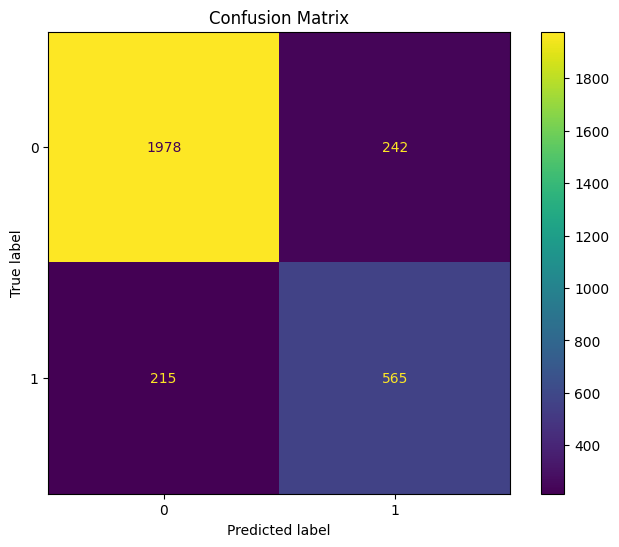

In [22]:
preproceso = preprocesamiento(revision)
preproceso.df = preproceso.df.sample(10000)
preproceso.crea_EDAD_NORM('EDAD')

X = preproceso.df.drop(columns=['TARGET'])
y = preproceso.df['TARGET'].to_numpy()

#Una práctica común es utilizar la división estándar, 70% para entrenamiento y el 30% para validación.
# MAs adelante se pueden utilizar Validación cruzada, Validación estratificada o Muestreo balanceado.
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.3, random_state=69)


#Se utiliza ColumnTransformer para ejustar el modelo incluyendo las transformaciones
ct = ColumnTransformer([('Quantile', QuantileTransformer(n_quantiles=10, random_state=0), ['INGRESO']),
                        ('MinMax',MinMaxScaler(), ['MORAS'] ),
                        ('Ohe_bi ',OneHotEncoder(handle_unknown='ignore', drop='first'), ['SEXO']),
                        ('Ohe',OneHotEncoder(handle_unknown='ignore'), ['ESTADO','ESTADOCIVIL'] ),
                        ('Normal',Normalizer(),['MARCACIONES','CONTACTOS','M1','C1','M2','C2','M3','C3'])
                        ]
                        , remainder='passthrough')#.set_output(transform='pandas')
ct_out = ct.fit(X_train)
X_train_trans = ct_out.transform(X_train)

 # Modelo de clasificación de Support Vector Machine (SVM)
n = 5
estimator = SVC(kernel='linear', coef0=1, probability=True) 
selector_SVC = RFE(estimator, n_features_to_select=n)
selector_SVC.fit(X_train_trans, y_train)
X_train_trans_red = selector_SVC.transform(X_train_trans)

 # Modelo de clasificación Regresion logistica con ajuste de desbalance
def ajuste_desbalance_LogReg(target):
    # Implementación de ajuste en caso de desbalanceo de clases para la implementación en LogisticRegression
    unique, counts = np.unique(target, return_counts=True)
    numero_clases = len(unique)
    val_TARGET_0 = unique[0]
    val_TARGET_1 = unique[1]
    cant_TARGET_0 = counts[0]
    cant_TARGET_1 = counts[1]
    total = cant_TARGET_0 + cant_TARGET_1
    peso_TARGET_0 = total / (numero_clases * cant_TARGET_0)
    peso_TARGET_1 = total / (numero_clases * cant_TARGET_1)
    return {val_TARGET_0: peso_TARGET_0, val_TARGET_1: peso_TARGET_1}
LR_balance = LogisticRegression(class_weight = ajuste_desbalance_LogReg(y_train)).fit(X_train_trans_red, y_train)

# implementacion del modelo completo
pipeline = Pipeline([
    ('Transformacion_var', ct_out),
    ('Reduccion_var', selector_SVC),
    ('clasificacion', LR_balance)
])

pipe = pipeline.fit(X_train, y_train)

def grafica_confusion_matrix(y_test, y_test_predictions):
    conf_matrix = confusion_matrix(y_test, y_test_predictions)
    fig, ax = plt.subplots(figsize=(8,6), dpi=100)
    display = ConfusionMatrixDisplay(conf_matrix)
    ax.set(title='Confusion Matrix')
    display.plot(ax=ax)

prediccion = pipe.predict(X_test)
grafica_confusion_matrix(y_test, prediccion)

In [25]:
#Descripcion del modelo completo
pipe

Pipeline(steps=[('Transformacion_var',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Quantile',
                                                  QuantileTransformer(n_quantiles=10,
                                                                      random_state=0),
                                                  ['INGRESO']),
                                                 ('MinMax', MinMaxScaler(),
                                                  ['MORAS']),
                                                 ('Ohe_bi ',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['SEXO']),
                                                 ('Ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ESTADO', 'ESTADOCIVIL']),
                                                 ('Normal', Normalizer(),
                                                  ['MARCACIONES', 'CONTACTOS',
                                                   'M1', 'C1', 'M2', 'C2', 'M3',
                                                   'C3'])])),
                ('Reduccion_var',
                 RFE(estimator=SVC(coef0=1, kernel='linear', probability=True),
                     n_features_to_select=5)),
                ('clasificacion',
                 LogisticRegression(class_weight={0: 0.6764592191727871,
                                                  1: 1.9167579408543265}))])

In [26]:
# Obtener las métricas de precisión, recall y F1-score
report = classification_report(y_test, prediccion)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      2220
           1       0.70      0.72      0.71       780

    accuracy                           0.85      3000
   macro avg       0.80      0.81      0.80      3000
weighted avg       0.85      0.85      0.85      3000



In [30]:
# Calcular el valor AUC-ROC
y_pred_prob = pipe.predict_proba(X_test)[:, 1]  # Probabilidad de clase positiva
auc_roc = roc_auc_score(y_test, y_pred_prob)
print("AUC-ROC Score:", auc_roc)

AUC-ROC Score: 0.9031782744282745


## 12.2 Clasificador K Vecinos

Una segunda opción a considerar es el clasificador K Vecinos (KNN) debido a las siguientes características presentes en los datos:

- Tamaño de muestra suficiente: KNN funciona mejor con un tamaño de muestra grande, ya que se basa en la cercanía de los vecinos. Un tamaño de muestra pequeño puede no representar adecuadamente los patrones en los datos.

- Estructura de datos no lineal: KNN es especialmente útil para datos con estructura no lineal o que no siguen una distribución específica. Es capaz de capturar patrones complejos sin hacer suposiciones sobre la forma de los datos.

- Datos sin sesgo: KNN tiene un mejor desempeño cuando los datos no presentan un sesgo significativo hacia una clase en particular. En caso de existir sesgo, podrían requerirse técnicas adicionales para equilibrar los datos, aunque en este caso no hay un sesgo pronunciado debido a que la data no está balanceada.

Las ventajas de utilizar KNN son: simplicidad, ya que no requiere suposiciones sobre la distribución de los datos ni ajustes de parámetros complejos; versatilidad, ya que puede ser aplicado tanto a problemas de clasificación como de regresión, y puede manejar diferentes tipos de datos; e interpretabilidad, dado que las predicciones de KNN se basan en los vecinos más cercanos, lo que permite una explicación lógica e intuitiva de las decisiones del modelo.

Por otro lado, las desventajas de KNN son: sensibilidad a la escala de las características, lo cual puede afectar su desempeño si las características tienen escalas diferentes; coste computacional, ya que el tiempo de ejecución aumenta con el tamaño del conjunto de datos, especialmente al buscar los vecinos más cercanos en grandes conjuntos de datos, por lo que se recomienda trabajar con muestras; y sensibilidad al ruido y a los valores atípicos, por lo que se debe realizar un buen proceso de ETL e ingeniería de características.

Además, la elección adecuada del parámetro K es crucial para el rendimiento de KNN, ya que un valor incorrecto puede generar sesgos o varianzas subóptimas en el modelo. Para abordar esta cuestión, se puede emplear la técnica de GridSearchCV.

En el código siguiente se realiza un preprocesamiento de los datos y se ajusta un pipeline que incluye el proceso de binning, análisis de componentes principales y el clasificador KNN. Se utilizan los datos de prueba para hacer predicciones y se visualiza una matriz de confusión. Además, se imprime un informe de clasificación que muestra las métricas de precisión, recall y F1-score, y se calcula el área bajo la curva ROC (AUC-ROC) para evaluar el rendimiento del modelo.

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      2222
           1       0.74      0.67      0.70       778

    accuracy                           0.85      3000
   macro avg       0.81      0.79      0.80      3000
weighted avg       0.85      0.85      0.85      3000

AUC-ROC Score: 0.8686872221926563


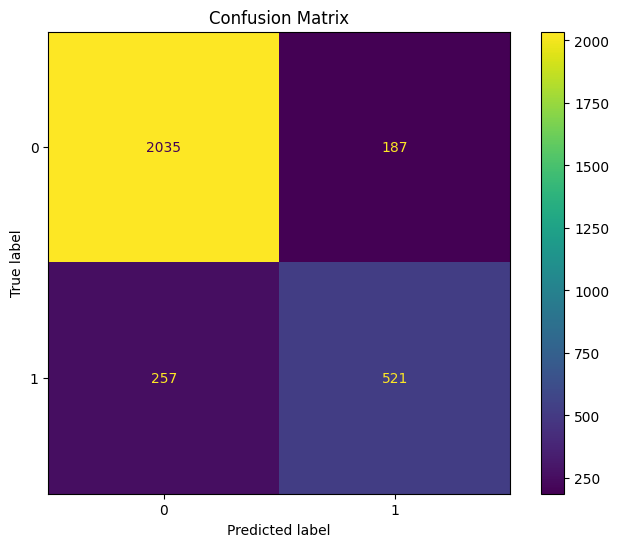

In [24]:
def grafica_confusion_matrix(y_test, y_test_predictions):
    conf_matrix = confusion_matrix(y_test, y_test_predictions)
    fig, ax = plt.subplots(figsize=(8,6), dpi=100)
    display = ConfusionMatrixDisplay(conf_matrix)
    ax.set(title='Confusion Matrix')
    display.plot(ax=ax)

preproceso = preprocesamiento(revision)
preproceso.df = preproceso.df.sample(10000)
preproceso.crea_EDAD_NORM('EDAD')

X = preproceso.df.drop(columns=['TARGET'])
y = preproceso.df['TARGET'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)


pipes_bining = []
for columna in X_train.columns:
    pipes_bining.append((columna + '_Tr', Pipeline([('columna', BinningProcess(variable_names=[columna]))]), [columna]))
preprocessor = ColumnTransformer(pipes_bining)
#preprocessor.fit(X_train, y_train)
# X_train_transf = preprocessor.transform(X_train)



pipe = Pipeline((
    ("BinningProcess", preprocessor),
    ("Principal_component_analysis", PCA(n_components=5)),
    ("KNeighborsClassifier", KNeighborsClassifier(n_neighbors=5))))

pipe.fit(X_train, y_train)
prediccion= pipe.predict(X_test)

grafica_confusion_matrix(y_test, prediccion)

# Obtener las métricas de precisión, recall y F1-score
report = classification_report(y_test, prediccion)
print("Classification Report:")
print(report)

# Calcular el valor AUC-ROC
y_pred_prob = pipe.predict_proba(X_test)[:, 1]  # Probabilidad de clase positiva
auc_roc = roc_auc_score(y_test, y_pred_prob)
print("AUC-ROC Score:", auc_roc)

In [37]:
preproceso = preprocesamiento(revision)
preproceso.df = preproceso.df.sample(1000)
preproceso.crea_EDAD_NORM('EDAD')

X = preproceso.df.drop(columns=['TARGET'])
y = preproceso.df['TARGET'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)


pipes_bining = []
for columna in X_train.columns:
    pipes_bining.append((columna + '_Tr', Pipeline([('columna', BinningProcess(variable_names=[columna]))]), [columna]))
preprocessor = ColumnTransformer(pipes_bining)
#preprocessor.fit(X_train, y_train)
# X_train_transf = preprocessor.transform(X_train)

pipe = Pipeline((
    ("BinningProcess", preprocessor),
    ("Principal_component_analysis", PCA(n_components=5)),
    ("KNeighborsClassifier", KNeighborsClassifier(n_neighbors=5))))
# pipe.fit(X_train, y_train)
# prediccion= pipe.predict(X_test)


# para revisar los parametros que se pueden utilizar en Grid
# pipe.get_params()
modelo_final = GridSearchCV(estimator = pipe,
                     param_grid = {'KNeighborsClassifier__n_neighbors': list(range(6,15))},
                     cv = 3)
modelo_final.fit(X_train, y_train)           
resultados = pd.DataFrame(modelo_final.cv_results_)
resultados

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_KNeighborsClassifier__n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.598760,0.041103,0.051035,8.169264e-04,6,{'KNeighborsClassifier__n_neighbors': 6},0.863248,0.836910,0.768240,0.822799,0.040049,2
1,1.605403,0.171106,0.047365,1.886774e-03,7,{'KNeighborsClassifier__n_neighbors': 7},0.871795,0.819742,0.751073,0.814203,0.049440,9
2,1.586835,0.066450,0.048699,1.248424e-03,8,{'KNeighborsClassifier__n_neighbors': 8},0.846154,0.832618,0.772532,0.817101,0.031996,7
3,1.451634,0.034762,0.050367,2.495808e-03,9,{'KNeighborsClassifier__n_neighbors': 9},0.854701,0.828326,0.768240,0.817089,0.036181,8
4,1.448299,0.038585,0.048032,2.973602e-07,10,{'KNeighborsClassifier__n_neighbors': 10},0.846154,0.836910,0.772532,0.818532,0.032745,5
5,1.453969,0.027086,0.046031,8.181894e-04,11,{'KNeighborsClassifier__n_neighbors': 11},0.880342,0.836910,0.759657,0.825636,0.049910,1
6,1.450301,0.041672,0.049366,2.626336e-03,12,{'KNeighborsClassifier__n_neighbors': 12},0.867521,0.824034,0.776824,0.822793,0.037037,3
7,1.458973,0.061071,0.050034,4.971411e-03,13,{'KNeighborsClassifier__n_neighbors': 13},0.867521,0.824034,0.776824,0.822793,0.037037,3
8,1.673384,0.089076,0.070046,1.575780e-02,14,{'KNeighborsClassifier__n_neighbors': 14},0.850427,0.836910,0.768240,0.818526,0.035983,6


implementar los siguientes algoritmos:

Regresión logísti  (Listo)ca
K Vecinos más cerca  (Listo)
  -
Máquinas de vectores de soporte  -
Naive bayes
Árboles de decisión clasi  (por hacer)ficación
Bosques aleatorios clas (por hacer)ificación


## 13 Métricas para evaluar algoritmos de clasificación

las métricas de precisión, recall y F1-score son ampliamente utilizadas para evaluar algoritmos de clasificación como regresión logística, KNN, SVM, Naive Bayes, árboles de decisión y bosques aleatorios. Estas métricas proporcionan una evaluación general del rendimiento del modelo en términos de precisión, capacidad para capturar instancias positivas y una combinación de precisión y recall.

- Precisión (precision_score): Es útil para medir la proporción de verdaderos positivos entre las predicciones positivas. Es especialmente importante en casos en los que los falsos positivos tienen un alto costo.- 
Recall (recall_score): Mide la proporción de verdaderos positivos que se capturan correctamente entre todas las instancias positivas reales. Es importante cuando el objetivo es minimizar los falsos negativo.
- 
F1-score (f1_score): Es una métrica que combina precisión y recall en un solo valor, lo que lo convierte en una medida general del rendimiento del modelo.


14. Explica cómo visualizas la implementación del modelo ganador, este podrá ser un punto
a considerar dentro de tu modelo pr5ferido.
15. Prepara un informe ejecutivo que detalle cada uno de los puntos de esta rúbrica, desde
la carga hasta la presentación de resultados y su implementación. El entregable de este
challenge será un archivo con el código y el reporte ejecutivo en formato PDF.